# Time Series Forecasting
---
## Supervised Learning with Neural Networks
### Chalkias Spyridon - Maraziaris Charalampos

## Necessary imports & Setup

In [ ]:
import os
import datetime
import random

from google.colab import drive
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model

from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, Bidirectional, Reshape, Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tqdm import tqdm

### Generate reproducible results by giving a specific seed.

In [ ]:
def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
# Set a seed!
seed = 156
reproducibleResults(seed)

## Preprocess & utility function definitions

In [ ]:
# Dataset filename
training_set_name = 'nasdaq2007_17.csv' 

at = 'https://github.com/spChalk/Time-Series-Forecasting-with-Deep-Learning/blob/main/data/'

# Read the dataset and instantiate the corresponding variables
training_set = pd.read_csv(at + training_set_name, dialect="excel-tab", index_col=0, header=None)

In [ ]:
df = training_set.transpose()

for col in df.columns:
    df[col] = pd.to_numeric(df[col], downcast="float")

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df

,a,aa,aaba,aapl,abc,abt,abx,adbe,adi,adm,admp,adp,adsk,aee,aem,aep,aes,aet,afl,agn,aig,aiv,all,amat,amd,amgn,amzn,an,antm,apa,apc,apd,aphb,ash,ati,atro,au,avp,avy,axgn,...,tmk,tmo,trow,trxc,ttnp,twx,txn,txt,uis,unh,unm,unp,ups,usb,utx,vfc,viav,vmc,vrsn,vz,wat,wba,wec,wen,wfc,whr,wmb,wmt,wor,wy,x,xel,xl,xlnx,xom,xray,xrx,yum,zbh,zion
1,11.144000,47.458000,13.880000,1.203700,13.991000,17.427000,15.944000,17.969999,28.961000,9.935000,59.330002,22.389999,8.400000,32.215000,9.515000,20.472000,6.3831,12.728000,27.980000,36.472000,1086.560059,29.027000,31.743999,12.377000,7.60,54.514000,33.049999,13.910000,36.056000,28.226000,22.764999,36.495998,2700.0000,12.412000,5.254600,1.461400,28.605000,25.004999,45.127998,2.150000,...,16.277000,18.673000,13.147000,30.600000,11.440,27.254999,16.375000,16.111000,107.199997,21.487000,10.634000,12.970000,51.009998,19.985001,28.896999,7.895700,15.828,34.216000,12.397000,26.403000,26.900000,27.645000,8.672100,3.8531,20.118999,45.222000,6.001100,44.983002,12.396000,14.816000,14.514000,11.350000,72.787003,24.125999,28.525000,17.285000,36.388000,8.266000,46.395000,47.668999
2,10.471000,45.869999,12.970000,1.158900,13.434000,16.694000,16.337000,16.780001,27.597000,9.893000,62.049999,22.093000,7.960000,32.111000,9.815000,19.639000,6.2966,12.490000,27.197001,35.610001,1047.359985,28.573000,31.267000,11.892000,7.21,52.729000,31.559999,13.410000,35.845001,27.790001,22.489000,35.480999,2550.0000,12.295000,5.228000,1.420100,29.598000,24.686001,44.435001,2.050000,...,16.033001,18.228001,12.924000,26.250000,11.660,26.261999,16.528000,15.638000,101.300003,21.225000,10.225000,12.733000,50.958000,19.444000,28.518999,7.755500,14.646,33.794998,11.735000,26.112000,26.190001,26.971001,8.500200,3.8009,19.771000,44.174999,5.682900,44.602001,12.265000,14.534000,14.224000,11.350000,70.884003,22.952999,28.191000,16.900999,35.202999,8.317200,45.814999,46.667999
3,10.828000,46.249001,13.290000,1.138500,13.195000,16.597000,16.775999,16.750000,27.885000,9.944000,64.599998,22.034000,7.740000,32.493999,9.905000,19.990999,6.3743,12.940000,27.018000,34.519001,1039.140015,28.895000,30.827000,11.901000,7.00,53.395000,31.480000,13.500000,37.471001,27.562000,22.469000,35.423000,2450.0000,12.363000,5.228000,1.543900,29.587999,24.927000,44.098999,2.460000,...,15.590000,18.538000,13.121000,24.049999,11.825,26.171000,16.520000,15.618000,99.400002,21.561001,10.346000,12.841000,50.764000,19.367001,28.065001,7.704300,14.782,33.776001,11.432000,26.142000,26.799999,26.583000,8.622900,3.5502,19.695000,44.493000,5.393600,44.890999,12.229000,14.267000,14.261000,11.273000,70.817001,22.937000,28.419001,17.016001,35.707001,8.278100,42.181000,46.570000
4,10.698000,47.852001,13.090000,1.143700,13.415000,16.760000,17.069000,16.840000,28.400999,9.925000,61.200001,22.077999,7.630000,32.215000,10.332000,20.160000,5.9597,13.143000,27.197001,35.263000,1039.310059,29.027000,30.604000,11.815000,7.05,53.108002,31.750000,13.510000,38.120998,28.948000,23.433001,35.370998,2400.0000,12.524000,5.192100,1.508500,29.809999,25.187000,44.098999,2.150000,...,15.646000,18.615000,13.181000,23.100000,11.275,26.152000,15.829000,15.747000,102.199997,22.048000,10.251000,12.926000,50.787998,19.504000,28.125999,7.670300,14.782,33.668999,12.020000,26.112000,26.410000,26.167000,8.687600,3.5245,19.665001,43.867001,5.335800,44.702999,12.317000,14.240000,14.242000,11.195000,71.314003,22.888000,28.797001,17.421000,35.104000,8.359100,41.582001,46.973999
5,10.910000,49.523998,13.450000,1.167900,13.471000,16.981001,16.712000,17.340000,28.952999,10.165000,62.049999,22.003000,7.770000,32.544998,10.098000,20.816000,6.0808,13.058000,27.424000,35.926998,1046.270020,29.429001,30.316000,12.006000,7.05,54.131001,33.000000,13.630000,37.865002,29.313999,23.232000,35.535999,2450.0000,12.241000,4.923900,1.532100,28.865000,25.862000,44.584000,2.410000,...,15.538000,19.011000,13.271000,22.799999,10.780,27.464001,15.796000,15.884000,105.500000,21.796000,10.372000,12.926000,50.640999,19.614000,28.42499

In [ ]:
# Stacks all the columns of a dataset and returns a new dataset with the stacked columns as a single column.
def stack_columns(dataframe):
    df = dataframe.copy()
    concatd_df = pd.concat([df, df.T.stack().reset_index(name='data')['data']], axis=1)
    return pd.DataFrame(concatd_df['data'])

In [ ]:
def plot_loss_vs_epochs_diagram(train_loss, val_loss, label):
    plt.figure(figsize=[10, 5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(f"Model's loss during the training on {label}")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training loss', 'Validation loss'], loc='upper right')
    plt.show()

In [ ]:
# Compares a stock price over the time with a predicted one
def visualise_prediction(test_set, predicted_stock_price, label):
    plt.figure(figsize=[15, 7])
    plt.plot(test_set, color = 'red', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
    plt.title(f'{label} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [ ]:
def visualise_predictions_seperately(test_set, predicted_stock_price, label):
    plt.figure(figsize=[12, 5])
    plt.plot(test_set, color = 'blue', label = 'Real Stock Price')
    plt.title(f'{label} Real Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=[12, 5])
    plt.plot(predicted_stock_price, color = 'red', label = 'Encoded Stock Price')
    plt.title(f'{label} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [ ]:
# Splits a dataset's column to a training set and a test set by a factor of 3
def split_datasets(data, label):
    return data[label].iloc[: 2*len(data)//3 ].to_numpy().reshape(-1, 1), \
            data[label].iloc[ 2*len(data)//3 :].to_numpy().reshape(-1, 1)

In [ ]:
# Compute and return the prime factors of a given number n
def prime_factors(n):
    if n == 1:
        return [1]
    i = 2
    factors = []
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.append(i)
    if n > 1:
        factors.append(n)
    return factors

## A ~ Time Series forecasting

In [ ]:
'''
    Recurrent Neural Network with stacked LSTM layers. 
'''
class LSTM_Model(tf.keras.Model):
    '''
        Input: 
        - lstm_dims: An iterable representing the number of stacked LSTM layers with 
                        their respective number of units. e.g: [5, 7, 9]
        - dropout: Dropout ratio for every LSTM layer 
    '''
    def __init__(self, lstm_dims, dropout=.2):
        super(LSTM_Model, self).__init__()
        
        self.multi_lstm_model = tf.keras.Sequential()
        for i in range(0, len(lstm_dims) - 1):
            self.multi_lstm_model.add(LSTM(units=lstm_dims[i], return_sequences=True, dropout=dropout))
        self.multi_lstm_model.add(LSTM(units=lstm_dims[-1], dropout=dropout))
        self.multi_lstm_model.add(Dense(units = 1))

    '''
        Loads data into the model.
    '''
    def load_data(self, training_set_scaled, n_time_steps=60, lag=1):
        
        self.n_time_steps = n_time_steps
        self.lag = lag

        # Create a data structure with the given number of lag and time-steps
        self.X_train = []
        self.y_train = []
        for i in range(n_time_steps, len(training_set_scaled)):
            self.X_train.append(training_set_scaled[i - n_time_steps : i : lag, 0])
            self.y_train.append(training_set_scaled[i, 0])
        self.X_train, self.y_train = np.array(self.X_train), np.array(self.y_train)
        self.X_train = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))

    '''
        Defines early stopping, compiles and runs the model on the loaded data
    '''
    def fit(self, batch_size=32, max_epochs=100):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
        
        self.multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        return self.multi_lstm_model.fit(self.X_train, self.y_train, epochs = max_epochs, batch_size = batch_size, 
                                                validation_split=0.1, callbacks=[early_stopping])

    def predict(self, label, inputs, test_set):
        X_test = []
        for i in range(self.n_time_steps, len(test_set) + self.n_time_steps):
            X_test.append(inputs[i - self.n_time_steps : i : self.lag, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        predicted_stock_price = self.multi_lstm_model.predict(X_test)

        return predicted_stock_price

In [ ]:
'''
    Creates a model with the given set of hyperparmeters, 
    scales the data, trains on a single stock price and makes
    predictions on that stock.
'''
def A__train_model_for_a_stock(df, hpars):

    # Gather hyperparameters
    label = hpars['label']
    dropout = hpars['dropout']
    lstm_dims = hpars['lstm_dims']
    n_time_steps = hpars['n_time_steps']
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    lag = hpars['lag']

    # Split and scale the data
    training_set, test_set = split_datasets(df, label)
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    test_inputs = df[label][len(df[label]) - len(test_set) -n_time_steps:].values.reshape(-1,1)
    test_inputs = sc.transform(test_inputs)

    # Create a model and fit the data
    model = LSTM_Model(lstm_dims, dropout)
    model.load_data(training_set_scaled, n_time_steps, lag)
    history = model.fit(batch_size, max_epochs)
    plot_loss_vs_epochs_diagram(history.history['loss'], history.history['val_loss'], label)

    # Make prediction and visualise it
    predicted_stock_price = model.predict(label, test_inputs, test_set)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)    

    visualise_prediction(test_set, predicted_stock_price, label)

'''
    Creates a model with the given set of hyperparmeters, 
    scales the data, trains on the first N stock prices and makes
    predictions on them.
'''
def A__train_model_for_N_stocks(df, hpars, N):

    dropout = hpars['dropout']
    lstm_dims = hpars['lstm_dims']
    n_time_steps = hpars['n_time_steps']
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    lag = hpars['lag']

    df = df.iloc[: , :N]

    training_set, test_set = train_test_split(df, test_size=.3, shuffle=False)
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(stack_columns(training_set).values)

    model = LSTM_Model(lstm_dims, dropout)
    model.load_data(training_set_scaled, n_time_steps, lag)
    history = model.fit(batch_size, max_epochs)
    plot_loss_vs_epochs_diagram(history.history['loss'], history.history['val_loss'], f'the first {N} stocks')

    for label in list(test_set.columns):
        test_inputs = df[label][len(df[label]) - len(test_set[label]) - n_time_steps:].values.reshape(-1,1)
        test_inputs = sc.transform(test_inputs)

        predicted_stock_price = model.predict(label, test_inputs, test_set[label].to_numpy().reshape(-1, 1))
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)    

        visualise_prediction(test_set[label].values, predicted_stock_price, label)

## B ~ Time Series Anomaly Detection with LSTM Autoencoders 

In [ ]:
'''
    Autoencoder with stacked LSTM layers. 
'''
class LSTM_Autoencoder(tf.keras.Model):
    def __init__(self):
        super(LSTM_Autoencoder, self).__init__()
    '''
        Builds a model with the given parameters.
        Input: 
        - lstm_dims: An iterable representing the first half of stacked LSTM layers with 
                        their respective number of units. e.g: [10, 5, 2]
            NOTE: Due to the nature of the autoencoder, the given layers are mirrored 
                    in the model. For example, the above input is translated into [10, 5, 2, 2, 5, 10]  
        
        - dropout: Dropout ratio for every LSTM layer 
    '''
    def build_model(self, lstm_dims, dropout=.2):    
            
        self.multi_lstm_model = tf.keras.Sequential()
        for i in range(0, len(lstm_dims) - 1):
            self.multi_lstm_model.add(LSTM(units=lstm_dims[i], return_sequences=True, dropout=dropout))
        self.multi_lstm_model.add(LSTM(units=lstm_dims[-1], dropout=dropout))

        self.multi_lstm_model.add(tf.keras.layers.RepeatVector(n=self.X_train.shape[1]))
        
        for i in range(1, len(lstm_dims) + 1):
            self.multi_lstm_model.add(LSTM(units=lstm_dims[len(lstm_dims) - i], return_sequences=True, dropout=dropout))

        self.multi_lstm_model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(units=self.X_train.shape[2])
            )
        )

    def load_data(self, training_set_scaled, n_time_steps=60, lag=1):
        
        self.n_time_steps = n_time_steps
        self.lag = lag

        self.X_train,  self.y_train = [], []
        for i in range(len(training_set_scaled) - n_time_steps):
            v = training_set_scaled[i:(i + n_time_steps):lag]
            self.X_train.append(v)        
            self.y_train.append(training_set_scaled[i + n_time_steps])
        self.X_train,  self.y_train = np.array(self.X_train), np.array(self.y_train)      

    def fit(self, batch_size=32, max_epochs=100):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

        self.multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        return self.multi_lstm_model.fit(self.X_train, self.y_train, epochs = max_epochs, batch_size = batch_size, 
                                                validation_split=0.1, callbacks=[early_stopping], shuffle=False)

    def predict(self, label, test_set_scaled, test_set):

        self.X_test,  self.y_test = [], []
        for i in range(len(test_set_scaled) - self.n_time_steps):
            v = test_set_scaled[i:(i + self.n_time_steps):self.lag]
            self.X_test.append(v)        
            self.y_test.append(test_set_scaled[i + self.n_time_steps])
        self.X_test, self.y_test = np.array(self.X_test), np.array(self.y_test)

        # Calculate the Mean Absolute Error (MAE) in order to spot anomalies
        train_pred = self.multi_lstm_model.predict(self.X_train)
        train_mae_loss = np.mean(np.abs(train_pred - self.X_train), axis=1)

        test_pred = self.multi_lstm_model.predict(self.X_test)
        test_mae_loss = np.mean(np.abs(test_pred - self.X_test), axis=1)

        return train_mae_loss, test_mae_loss

    # Plot the anomalies on a graph using a given thresohold
    def detect_and_plot_anomalies(self, threshold, test_set, test_mae_loss, label):
        test_score_df = pd.DataFrame(index=[i for i in range(self.n_time_steps, len(test_set))])
        test_score_df['loss'] = test_mae_loss
        test_score_df['threshold'] = threshold
        test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
        test_score_df['price'] = test_set.flatten()[self.n_time_steps:]

        plt.figure(figsize=[12, 7])
        plt.plot(test_score_df.loss, label='Loss')
        plt.plot(test_score_df.threshold, label='Threshold')
        plt.title(f'Anomaly Threshold for {label}')
        plt.xticks(rotation=25)
        plt.legend()
        plt.show()

        anomalies = test_score_df[test_score_df.anomaly == True]

        plt.figure(figsize=[10, 7])
        plt.plot(
            [i for i in range(self.n_time_steps, len(test_set))], 
            test_set[self.n_time_steps:], 
            label='Stock Price'
            );

        sns.scatterplot(
            x=anomalies.index,
            y=anomalies.price.to_numpy().reshape(-1, 1).flatten(),
            color=sns.color_palette()[3],
            s=52,
            label='Anomaly'
        )
        
        plt.title(f'Anomalies in {label}')
        plt.xticks(rotation=25)
        plt.legend()
        plt.show()

In [ ]:
def B__train_model_for_a_stock(df, hpars):

    label = hpars['label']
    dropout = hpars['dropout']
    lstm_dims = hpars['lstm_dims']
    n_time_steps = hpars['n_time_steps']
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    lag = hpars['lag']
    threshold = hpars['anomaly_threshold']

    training_set, test_set = split_datasets(df, label)
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    test_set_scaled = sc.transform(test_set)

    model = LSTM_Autoencoder()
    model.load_data(training_set_scaled, n_time_steps, lag)
    model.build_model(lstm_dims, dropout)
    history = model.fit(batch_size, max_epochs)
    plot_loss_vs_epochs_diagram(history.history['loss'], history.history['val_loss'], label)

    train_mae_loss, test_mae_loss = model.predict(label, test_set_scaled, test_set)
    
    plt.figure(figsize = [15, 10])
    sns.histplot(train_mae_loss, bins=50, kde=True, stat="density", linewidth=1)
    plt.title(f'Anomaly Detector for {label}')
    plt.show()

    # If the anomaly threshold is not given by the user, then it is 
    # being automatically computed by taking the max of the training set's MAE
    if hpars['anomaly_threshold'] is None:
        threshold = float(max(train_mae_loss))

    model.detect_and_plot_anomalies(threshold, test_set, test_mae_loss, label)
    visualise_prediction(test_set, sc.inverse_transform(test_mae_loss), label)

def B__train_model_for_N_stocks(df, hpars, N):

    dropout = hpars['dropout']
    lstm_dims = hpars['lstm_dims']
    n_time_steps = hpars['n_time_steps']
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    lag = hpars['lag']
    threshold = hpars['anomaly_threshold']

    df = df.iloc[: , :N]

    training_set, test_set = train_test_split(df, test_size=.2, shuffle=False)
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(stack_columns(training_set).values)

    if not hpars['anomaly_threshold'] is None:
        threshold = hpars['anomaly_threshold']

    model = LSTM_Autoencoder()
    model.load_data(training_set_scaled, n_time_steps, lag)
    model.build_model(lstm_dims, dropout)
    history = model.fit(batch_size, max_epochs)
    plot_loss_vs_epochs_diagram(history.history['loss'], history.history['val_loss'], f'the first {N} stocks')

    for k, label in enumerate(list(test_set.columns)):
        test_inputs = sc.transform(test_set[label].to_numpy().reshape(-1, 1))

        train_mae_loss, test_mae_loss = model.predict(label, test_inputs, test_set[label].to_numpy().reshape(-1, 1))

        if k == 0:
            plt.figure(figsize = [12, 7])
            sns.histplot(train_mae_loss, bins=50, kde=True, stat="density", linewidth=1)
            plt.title(f'Anomaly Detector for the training set')
            plt.show()

        if hpars['anomaly_threshold'] is None:
            threshold = float(max(train_mae_loss))

        model.detect_and_plot_anomalies(threshold, test_set[label].to_numpy().reshape(-1, 1), test_mae_loss, label)
        visualise_prediction(test_set[label].values, sc.inverse_transform(test_mae_loss), label) 

## C ~ Autoencoders for the compression of stock market time series

In [ ]:
class Conv_Autoencoder(tf.keras.Model):
    '''
    Input:
        - conv_filters: Iterable representing the convolution layers and their corresponding filters. e.g [32, 10]
        - kernels: Iterable representing the kernels of the convolution layers. e.g [3, 3]
        - window_length: The window size that the input data is being divided into
        - latent_dim: Dimension of the "bottleneck" layer

    Note considering the window size:
    - As with every parameter, window size is fully defined by the user.
    - The model computes the prime factors of the window size.
    - If the number of the prime factors is less or equal than the number of the convolution layers requested,
        then the convolution layers along with their kernels are being trimmed, in order to match the 
        length of the prime factors.
    - In the other case, the prime factors are being trimmed in order to match the convolution filters and the pooling/upsampling layers
        reduce/enhance the input's dimension based on the prime factors' values. 
    '''
    def __init__(self, conv_filters, kernels, window_length, latent_dim):
        super(Conv_Autoencoder, self).__init__()
        
        pf = prime_factors(window_length)
        if len(pf) <= len(conv_filters):
            conv_filters = conv_filters[:len(pf)]
        else:
            pf = pf[:len(conv_filters)]

        # Define input
        input_window = Input(shape=(window_length, 1))

        # Stack convolution and pooling layers
        cx = Conv1D(conv_filters[0], kernels[0], activation="relu", padding="same")(input_window)
        x = MaxPooling1D(pf[0], padding="same")(cx)
        for i in range(1, len(conv_filters)):
            cx = Conv1D(conv_filters[i], kernels[i], activation="relu", padding="same")(x)
            x = MaxPooling1D(pf[i], padding="same")(cx)
        # Flatten output and define the bottleneck layer
        x = Flatten()(x)
        x = Dense(latent_dim, activation="relu")(x)
        # Define encoder
        self.encoder = Model(input_window, x)

        curr_dim = window_length
        for factor in pf:
            curr_dim = curr_dim / factor
        # Build the decoder 
        x = Dense(int(curr_dim) * conv_filters[-1], activation="relu")(x)
        x = Reshape(( int(curr_dim) , conv_filters[-1]))(x)

        for i in range(1, len(conv_filters) + 1):
            cx = Conv1D(conv_filters[len(conv_filters) - i], kernels[len(kernels) - i], activation="relu", padding="same")(x)
            x = UpSampling1D(pf[len(pf) - i])(cx)

        decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) 
        
        self.autoencoder = Model(input_window, decoded)
        self.autoencoder.summary()
        
    def fit(self, x_train, x_test, max_epochs=100, batch_size=32):

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
        
        self.autoencoder.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
        
        history = self.autoencoder.fit(x_train, x_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, x_test), 
                        callbacks=[early_stopping])
        return history

    def predict(self, x_test):
        return self.encoder.predict(x_test)

In [ ]:
def C__train_model_for_a_stock(df, hpars):

    window_size = hpars['window_size']
    if hpars['window_size'] is None:
        window_size = 10
    latent_dim = hpars['latent_dim']
    if hpars['latent_dim'] is None:
        latent_dim = 3
    label = hpars['label']
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    conv_filters = hpars['conv_filters']
    kernels = hpars['kernels']

    scaler = MinMaxScaler(feature_range=(0, 1))

    x_train_nonscaled, x_test_nonscaled = train_test_split(df[label].values, test_size=.3, shuffle=False)

    # Chop the data into windows
    x_train = np.array([x_train_nonscaled[x : x + window_size] for x in range(0, len(x_train_nonscaled) - window_size, window_size)])
    x_test = np.array([x_test_nonscaled[x : x + window_size] for x in range(0, len(x_test_nonscaled) - window_size, window_size)])

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    model = Conv_Autoencoder(conv_filters, kernels, window_size, latent_dim)
    h = model.fit(x_train, x_test, max_epochs, batch_size)
    plot_loss_vs_epochs_diagram(h.history['loss'], h.history['val_loss'], label)

    predicted_stock_price = model.predict(x_test)
    predicted_stock_price = np.array([np.mean(i) for i in predicted_stock_price])

    visualise_predictions_seperately(x_test_nonscaled, predicted_stock_price.flatten(), label)

def C__train_model_for_N_stocks(df, hpars, N):

    window_size = hpars['window_size']
    if hpars['window_size'] is None:
        window_size = 10
    latent_dim = hpars['latent_dim']
    if hpars['latent_dim'] is None:
        latent_dim = 3
    batch_size = hpars['batch_size']
    max_epochs = hpars['max_epochs']
    conv_filters = hpars['conv_filters']
    kernels = hpars['kernels']

    df = df.iloc[: , :N]

    x_train_nonscaled, x_test_nonscaled = train_test_split(df, test_size=.3, shuffle=False)

    train_nonscaled, test_nonscaled = stack_columns(x_train_nonscaled).values, stack_columns(x_test_nonscaled).values

    train_nonscaled = train_nonscaled.flatten()
    test_nonscaled = test_nonscaled.flatten()

    x_train = np.array([train_nonscaled[x : x + window_size] for x in range(0, len(train_nonscaled) - window_size, window_size)])
    x_test = np.array([test_nonscaled[x : x + window_size] for x in range(0, len(test_nonscaled) - window_size, window_size)])

    scaler = MinMaxScaler(feature_range = (0, 1))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    model = Conv_Autoencoder(conv_filters, kernels, window_size, latent_dim)
    h = model.fit(x_train, x_test, max_epochs, batch_size)
    plot_loss_vs_epochs_diagram(h.history['loss'], h.history['val_loss'], f'the first {N} stocks')

    for i, label in enumerate(list(x_test_nonscaled.columns)): 
        t = np.array([x_test_nonscaled[label].values[x : x + window_size] for x in range(0, len(x_test_nonscaled[label].values) - window_size, window_size)])
        t = scaler.transform(t)
        t =  t.reshape(t.shape[0], t.shape[1], 1)
        predicted_stock_price = model.predict(t)
        predicted_stock_price = np.array([np.mean(i) for i in predicted_stock_price])
        visualise_predictions_seperately(x_test_nonscaled[label].values, predicted_stock_price.flatten(), label)

--------------------------------------------------------------------------------
## Results
--------------------------------------------------------------------------------

In [ ]:
hp_A_1_stock = {'lstm_dims':[500, 500, 500, 500, 500], 'dropout':0.25, 'label':'aapl', 'n_time_steps':60, 'lag':2, 'batch_size':128, 'max_epochs':100}
hp_A_N_stock = {'lstm_dims':[100, 100], 'dropout':0.25, 'n_time_steps':60, 'lag':2, 'batch_size':128, 'max_epochs':100}
hp_B_1_stock = {'lstm_dims':[50, 10], 'label':'aapl', 'dropout':0.2, 'n_time_steps':30, 'lag':1, 'batch_size':64, 'max_epochs':100, 'anomaly_threshold':0.5}
hp_B_N_stock = {'lstm_dims':[50, 10], 'dropout':0.2, 'n_time_steps':30, 'lag':1, 'batch_size':64, 'max_epochs':100, 'anomaly_threshold':0.5}
hp_C = {'conv_filters':[10, 10, 5], 'kernels':[3, 3, 3], 'batch_size':64, 'max_epochs':75, 'window_size':30, 'latent_dim':3}

### A

- `lstm_dims`: Number of stacked LSTM layers and their corresponding number of units. e.g: [50, 50] stands for 2 stacked LSTM layers each one made up of 50 units.
- `label`: 
    - In case `train_model_for_a_stock` is run, label corresponds to the requested stock to train on.
    - In case `train_model_for_N_stocks` is run, it is being ignored.
- `dropout`: Dropout probability on LSTM layers.
- `n_time_steps`: The number of steps the model will look in order to predict a label. e.g [x1, x2, x3] -> [y1] stands for `n_time_steps=3`
- `lag`: The parsing step in order to predict a label. e.g [1,2,3,4,5] => [6] corresponds to `lag=1`, while [1,3,5] => [6] corresponds to `lag=2` etc.
- `batch_size`: Batch size for training
- `max_epochs`: Number of maximum epochs to train the model.

In [ ]:
def test_batch(func, df, hp):
    train_set_size = df.shape[0]
    batch_sizes = []
    i = 4
    while (i < train_set_size):
        batch_sizes.append(i)
        i *= 2
    batch_sizes.append(i)  
    for bs in batch_sizes:
        print('Batch size is: ', bs)
        hp['batch_size'] = bs
        func(df, hp)

def test_dropout(func, df, hp):
    dropout_probs = [ 0.1 * i for i in range(0, 10) ]
    for dp in dropout_probs:
        print('Dropout is: ', dp)
        hp['dropout'] = dp
        func(df, hp)

def test_time_steps(func, df, hp):
    train_set_size = df.shape[0]
    time_steps = [1,2,3,4] + [5, 10, 30, 50, 70, 100, 150, 200, 250]
    for ts in time_steps:
        print('Time step is: ', ts)
        hp['n_time_steps'] = ts
        func(df, hp)

def test_lag(func, df, hp):
      lag = [1] + [ 2*i for i in range(1, 25)]
      for lg in lag:
          print('Lag is: ', lg)
          hp['lag'] = lg  # TODO: This should probably be tested with TSteps
          func(df, hp)

def test_dims(func, df, hp):
      one_layer_dims = [50, 100, 200, 300, 400, 500, 600]
      two_layers = [ [i,i] for i in one_layer_dims ]
      three_layers = [ [i,i,i] for i in one_layer_dims ]
      four_layers = [ [i,i,i,i] for i in one_layer_dims ]
      five_layers = [ [i,i,i,i,i] for i in one_layer_dims ]
      six_layers = [ [i,i,i,i,i,i] for i in one_layer_dims ]
      test_dim = two_layers + three_layers + four_layers + five_layers + six_layers
      print(test_dim)
      for dm in test_dim:
          print('LSTM dims are: ', dm)
          hp['lstm_dims'] = dm
          func(df, hp)

def test_epochs(df, hp):
      epochs = [25,50,100,150,200,300,400]
      for ep in epochs:
          print('Max epochs are: ', ep)
          hp['max_epochs'] = ep
          func(df, hp)

Epoch 1/100
71/71 [==============================] - 6s 22ms/step - loss: 0.0044 - mean_absolute_error: 0.0464 - val_loss: 8.6061e-04 - val_mean_absolute_error: 0.0241
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 9.1127e-04 - mean_absolute_error: 0.0239 - val_loss: 6.8591e-04 - val_mean_absolute_error: 0.0208
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 7.7389e-04 - mean_absolute_error: 0.0217 - val_loss: 5.2901e-04 - val_mean_absolute_error: 0.0175
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 7.3377e-04 - mean_absolute_error: 0.0210 - val_loss: 5.3664e-04 - val_mean_absolute_error: 0.0177
Epoch 5/100
71/71 [==============================] - 1s 10ms/step - loss: 7.3440e-04 - mean_absolute_error: 0.0211 - val_loss: 5.6608e-04 - val_mean_absolute_error: 0.0184


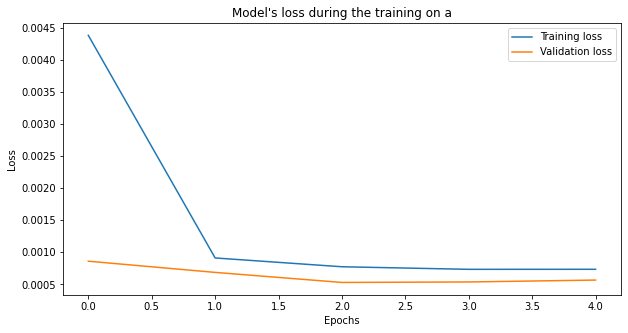

Epoch 1/100
71/71 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0483 - val_loss: 7.2897e-05 - val_mean_absolute_error: 0.0072
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0434 - val_loss: 2.8571e-04 - val_mean_absolute_error: 0.0151
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0391 - val_loss: 6.9380e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0373 - val_loss: 8.4766e-05 - val_mean_absolute_error: 0.0076
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0357 - val_loss: 1.0209e-04 - val_mean_absolute_error: 0.0083


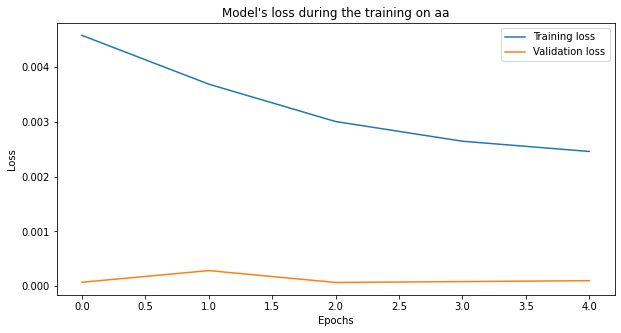

Epoch 1/100
71/71 [==============================] - 1s 10ms/step - loss: 4.4177e-04 - mean_absolute_error: 0.0158 - val_loss: 1.2192e-04 - val_mean_absolute_error: 0.0090
Epoch 2/100
71/71 [==============================] - 1s 10ms/step - loss: 4.2801e-04 - mean_absolute_error: 0.0155 - val_loss: 1.2649e-04 - val_mean_absolute_error: 0.0091
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 4.3159e-04 - mean_absolute_error: 0.0156 - val_loss: 9.7824e-05 - val_mean_absolute_error: 0.0079
Epoch 4/100
71/71 [==============================] - 1s 10ms/step - loss: 4.1998e-04 - mean_absolute_error: 0.0153 - val_loss: 1.4738e-04 - val_mean_absolute_error: 0.0101
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 4.2612e-04 - mean_absolute_error: 0.0153 - val_loss: 1.4430e-04 - val_mean_absolute_error: 0.0100


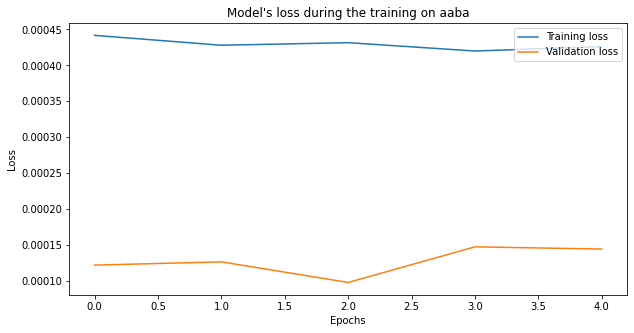

Epoch 1/100
71/71 [==============================] - 1s 10ms/step - loss: 4.8076e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0016 - val_mean_absolute_error: 0.0324
Epoch 2/100
71/71 [==============================] - 1s 10ms/step - loss: 4.2112e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0016 - val_mean_absolute_error: 0.0325
Epoch 3/100
71/71 [==============================] - 1s 10ms/step - loss: 4.2606e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0016 - val_mean_absolute_error: 0.0323
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 3.9865e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0020 - val_mean_absolute_error: 0.0367
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 4.0728e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0021 - val_mean_absolute_error: 0.0380


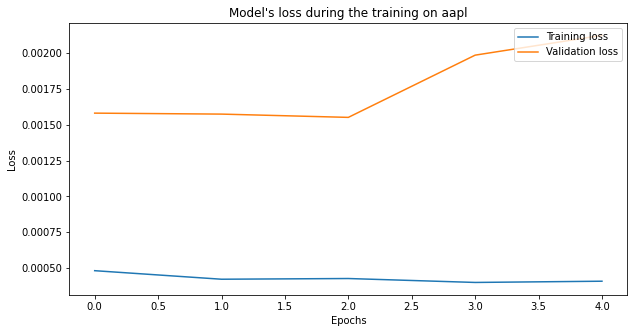

Epoch 1/100
71/71 [==============================] - 1s 9ms/step - loss: 1.3670e-04 - mean_absolute_error: 0.0090 - val_loss: 2.3257e-04 - val_mean_absolute_error: 0.0122
Epoch 2/100
71/71 [==============================] - 1s 10ms/step - loss: 1.2495e-04 - mean_absolute_error: 0.0086 - val_loss: 2.0674e-04 - val_mean_absolute_error: 0.0113
Epoch 3/100
71/71 [==============================] - 1s 10ms/step - loss: 1.3353e-04 - mean_absolute_error: 0.0089 - val_loss: 2.3151e-04 - val_mean_absolute_error: 0.0121
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 1.2828e-04 - mean_absolute_error: 0.0087 - val_loss: 2.7903e-04 - val_mean_absolute_error: 0.0135


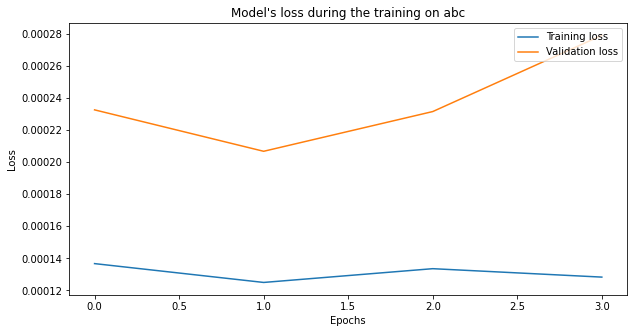

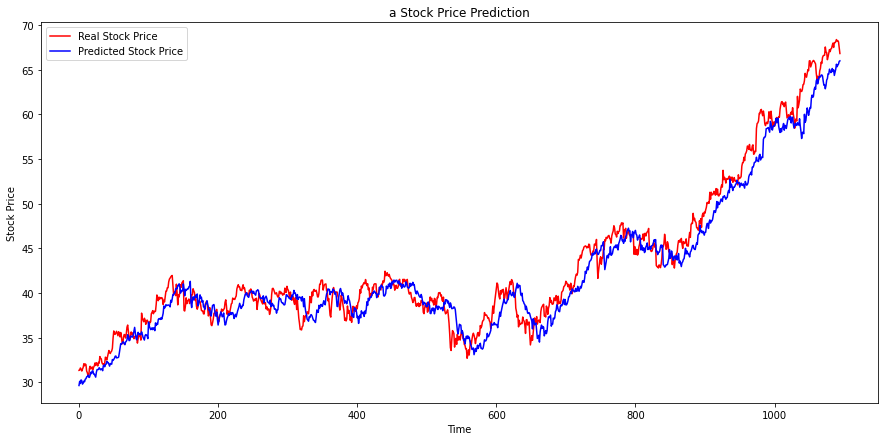

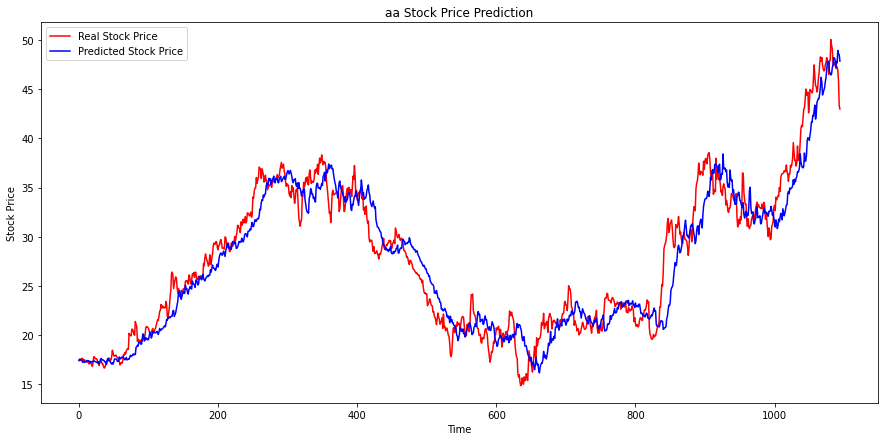

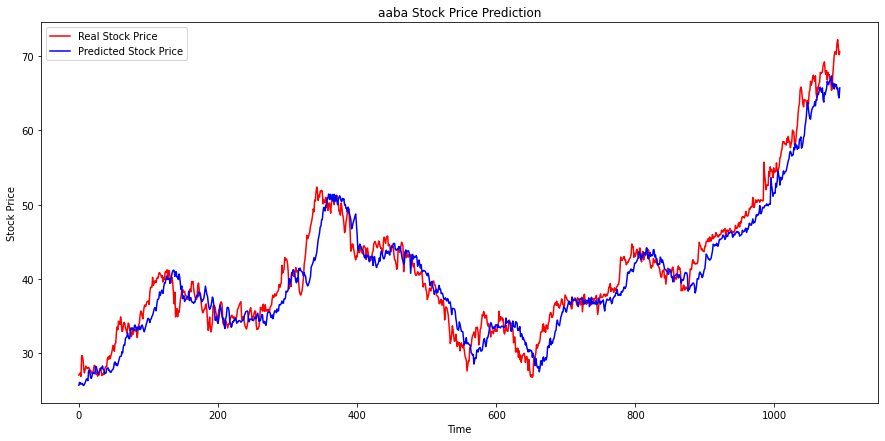

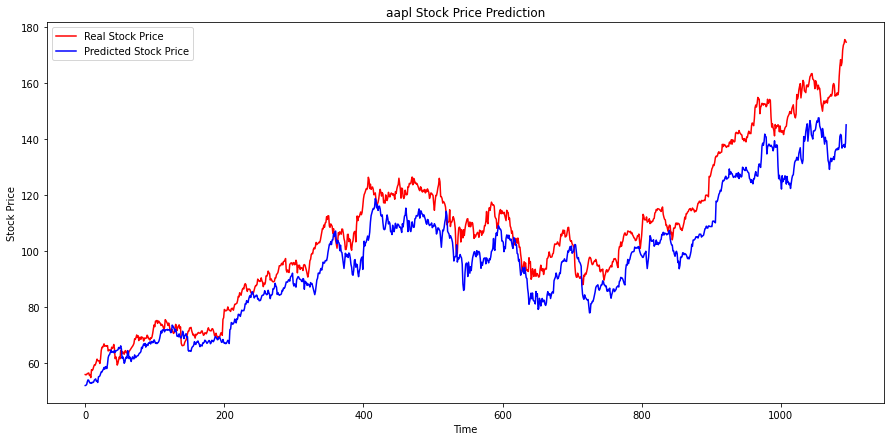

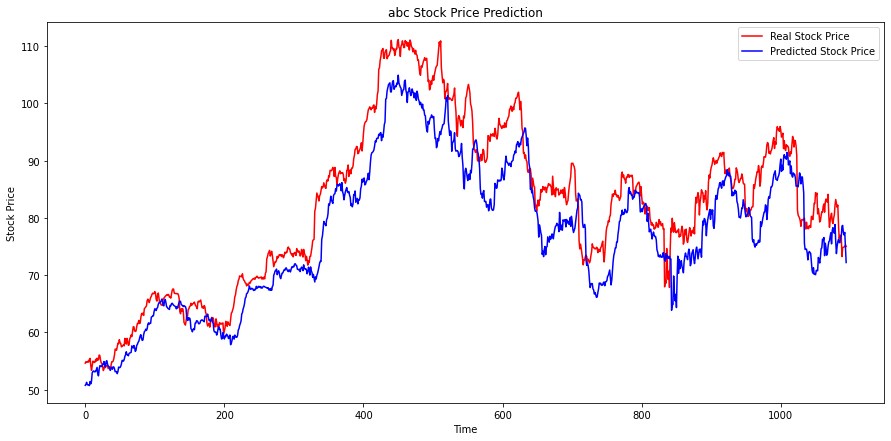

In [ ]:
hyperparameters = {'lstm_dims':[50, 50], 'dropout':0.0, 'n_time_steps':60, 'lag':10, 'batch_size':32, 'max_epochs':100}
A__train_model_for_N_stocks(df, hyperparameters, 5)

Epoch 1/100
67/67 [==============================] - 6s 22ms/step - loss: 0.0078 - mean_absolute_error: 0.0544 - val_loss: 0.0236 - val_mean_absolute_error: 0.1275
Epoch 2/100
67/67 [==============================] - 1s 9ms/step - loss: 7.9013e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0159 - val_mean_absolute_error: 0.1047
Epoch 3/100
67/67 [==============================] - 1s 9ms/step - loss: 7.8123e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0139 - val_mean_absolute_error: 0.0982
Epoch 4/100
67/67 [==============================] - 1s 9ms/step - loss: 7.3839e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0119 - val_mean_absolute_error: 0.0916
Epoch 5/100
67/67 [==============================] - 1s 9ms/step - loss: 7.3130e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0119 - val_mean_absolute_error: 0.0912
Epoch 6/100
67/67 [==============================] - 1s 9ms/step - loss: 7.1203e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0110 - val_mean_absolute_error: 0.0886
E

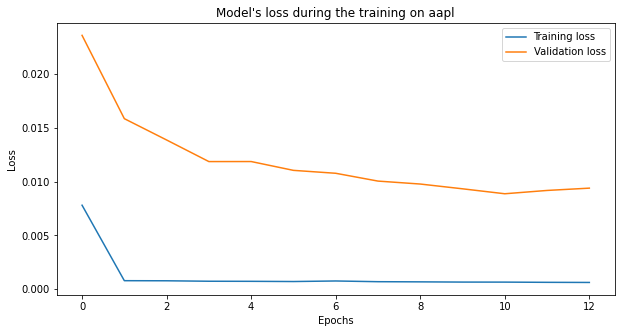

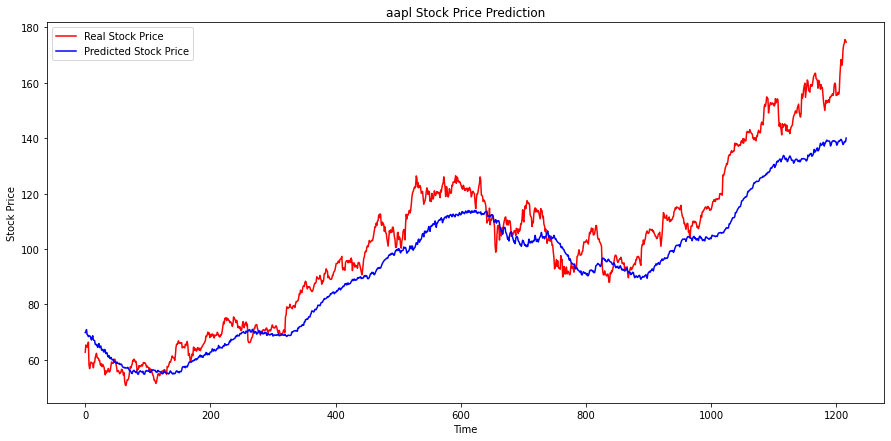

In [ ]:
hyperparameters = {'lstm_dims':[50, 50], 'label':'aapl', 'dropout':0.0, 'n_time_steps':60, 'lag':10, 'batch_size':32, 'max_epochs':100}
A__train_model_for_a_stock(df, hyperparameters)

### B

Epoch 1/100
71/71 [==============================] - 11s 60ms/step - loss: 0.0060 - mean_absolute_error: 0.0615 - val_loss: 0.0079 - val_mean_absolute_error: 0.0819
Epoch 2/100
71/71 [==============================] - 2s 35ms/step - loss: 0.0038 - mean_absolute_error: 0.0490 - val_loss: 0.0060 - val_mean_absolute_error: 0.0714
Epoch 3/100
71/71 [==============================] - 3s 35ms/step - loss: 0.0035 - mean_absolute_error: 0.0473 - val_loss: 0.0056 - val_mean_absolute_error: 0.0696
Epoch 4/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0058 - val_mean_absolute_error: 0.0717
Epoch 5/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0033 - mean_absolute_error: 0.0462 - val_loss: 0.0054 - val_mean_absolute_error: 0.0691
Epoch 6/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0033 - mean_absolute_error: 0.0461 - val_loss: 0.0052 - val_mean_absolute_error: 0.0680
Epoch 7/100
71/

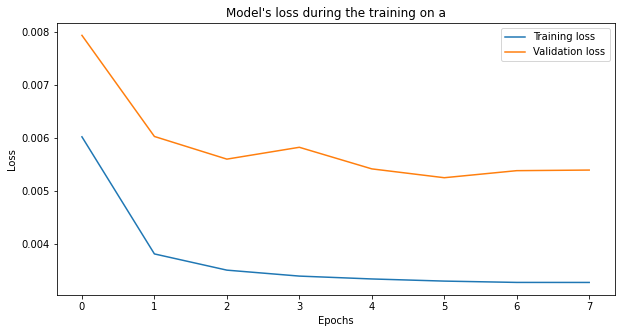

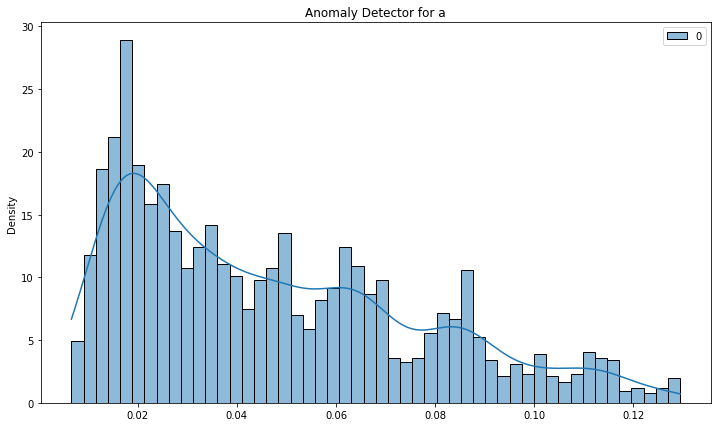

Epoch 1/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0715 - mean_absolute_error: 0.2361 - val_loss: 0.0917 - val_mean_absolute_error: 0.2995
Epoch 2/100
71/71 [==============================] - 3s 35ms/step - loss: 0.0624 - mean_absolute_error: 0.2296 - val_loss: 0.1050 - val_mean_absolute_error: 0.3216
Epoch 3/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0620 - mean_absolute_error: 0.2298 - val_loss: 0.1228 - val_mean_absolute_error: 0.3485


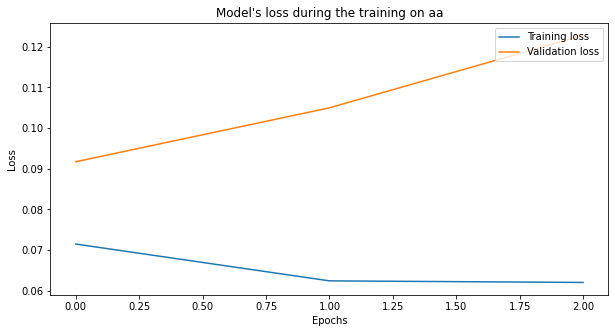

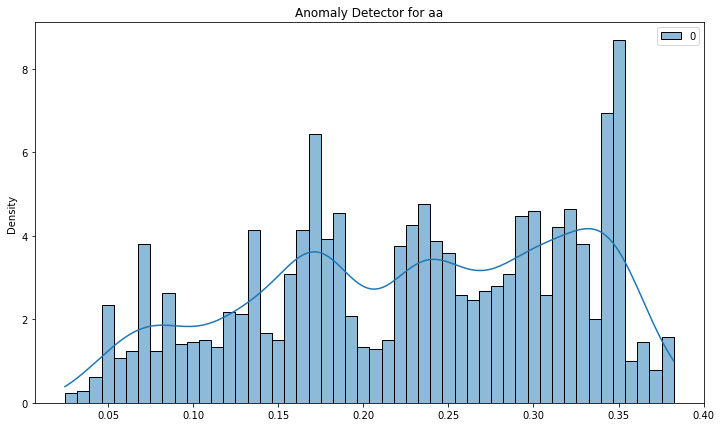

Epoch 1/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0186 - mean_absolute_error: 0.1091 - val_loss: 0.0027 - val_mean_absolute_error: 0.0448
Epoch 2/100
71/71 [==============================] - 3s 35ms/step - loss: 0.0081 - mean_absolute_error: 0.0802 - val_loss: 0.0029 - val_mean_absolute_error: 0.0464
Epoch 3/100
71/71 [==============================] - 3s 36ms/step - loss: 0.0081 - mean_absolute_error: 0.0802 - val_loss: 0.0031 - val_mean_absolute_error: 0.0472


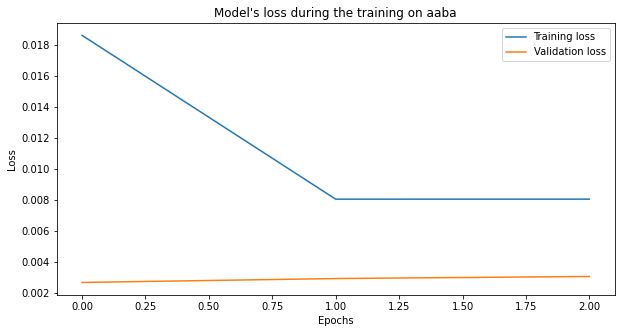

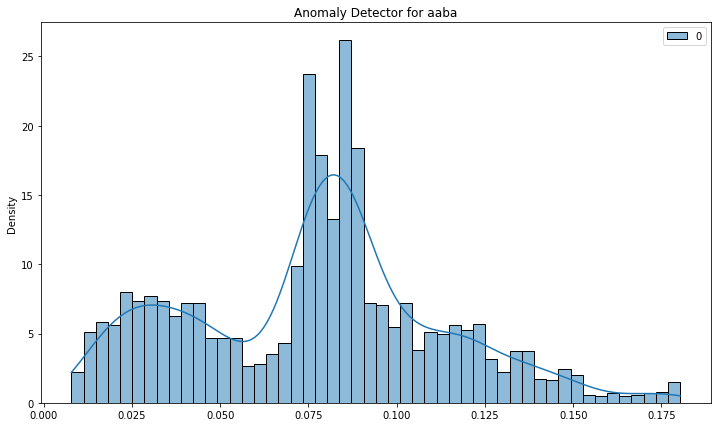

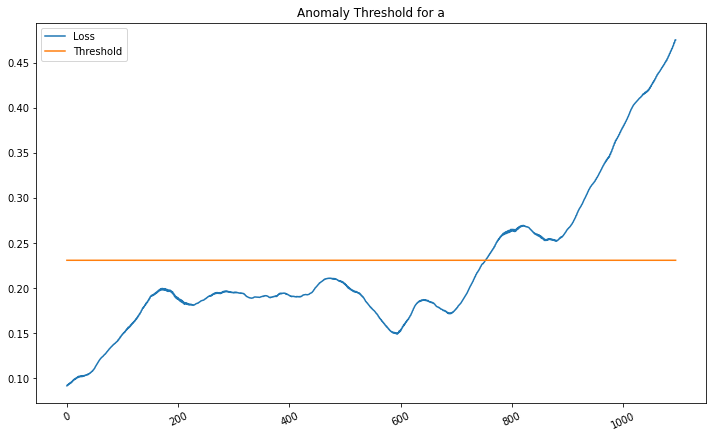

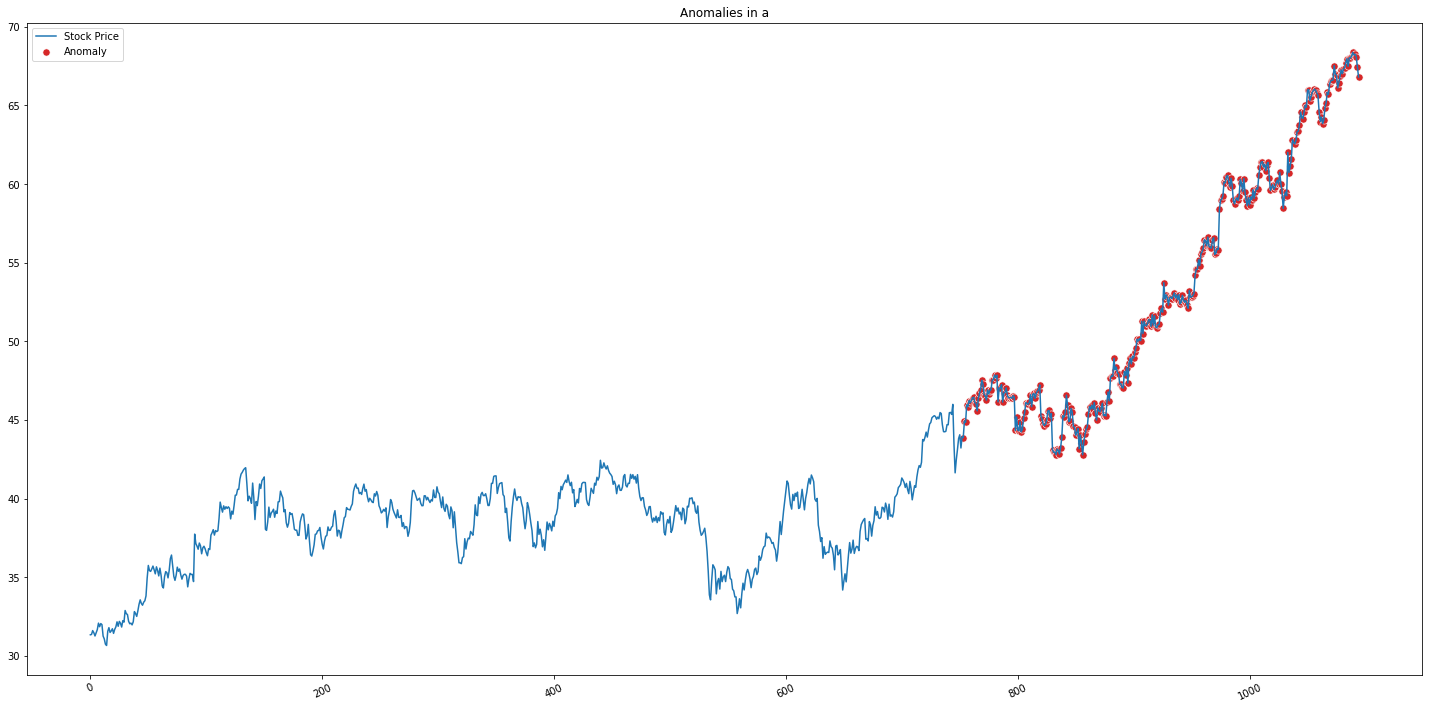

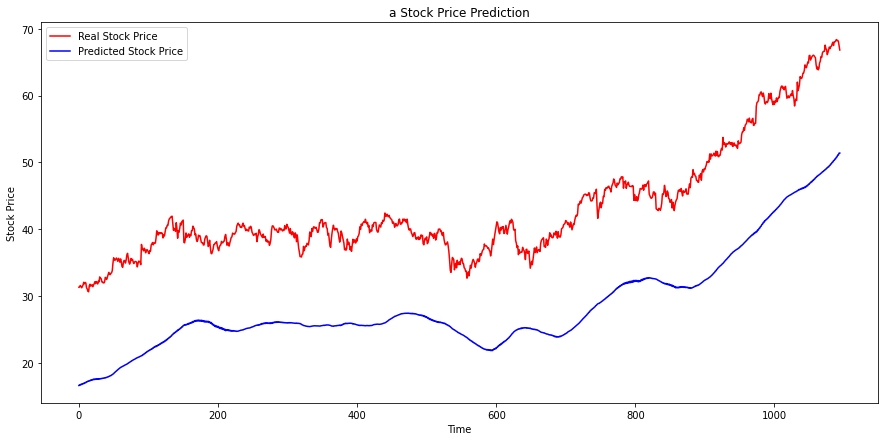

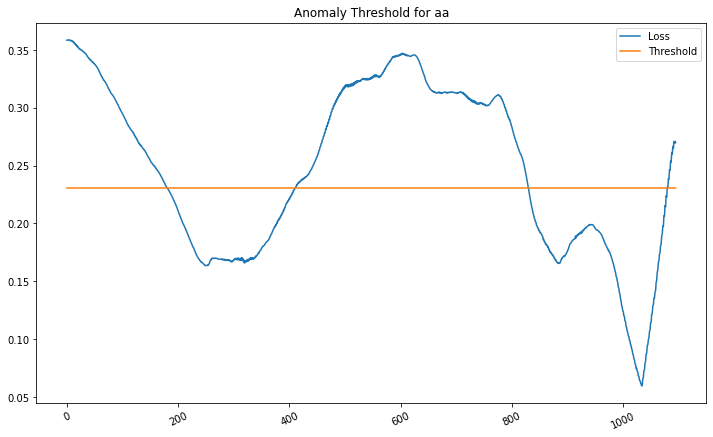

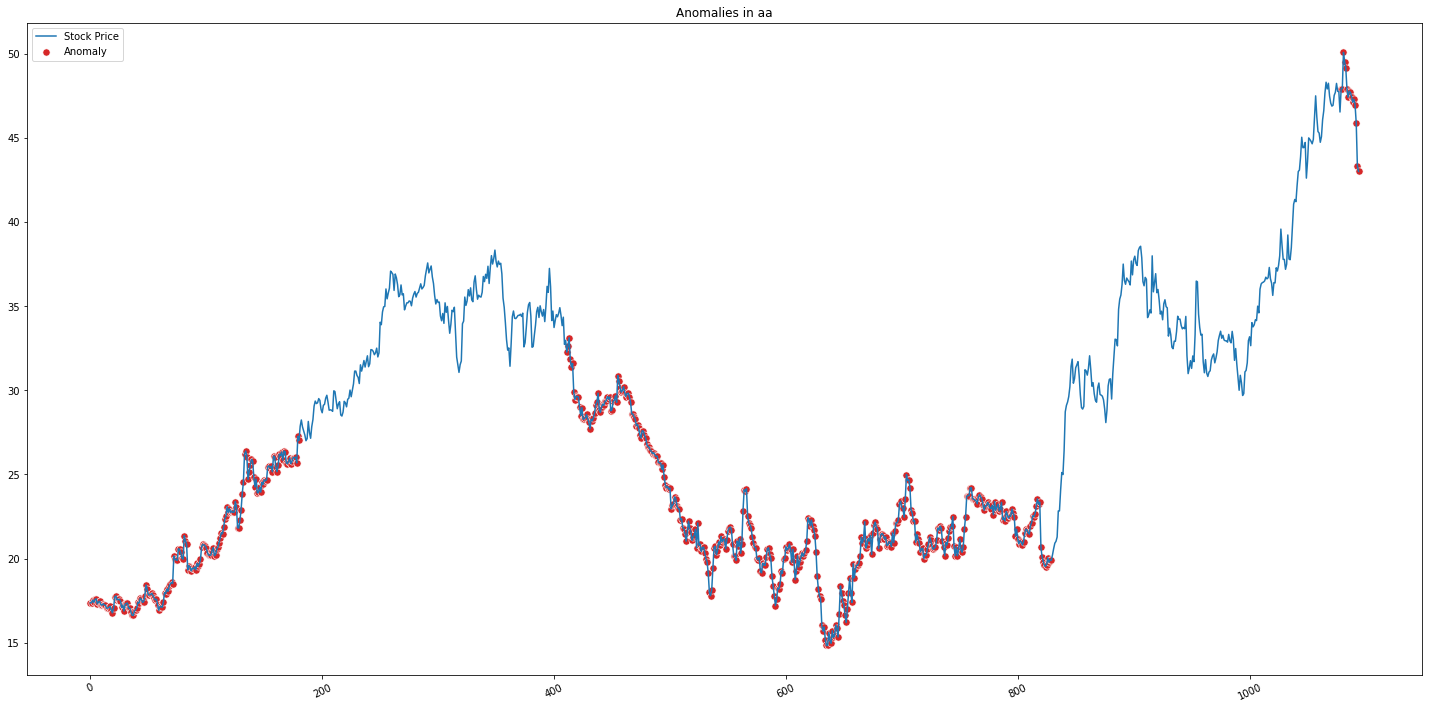

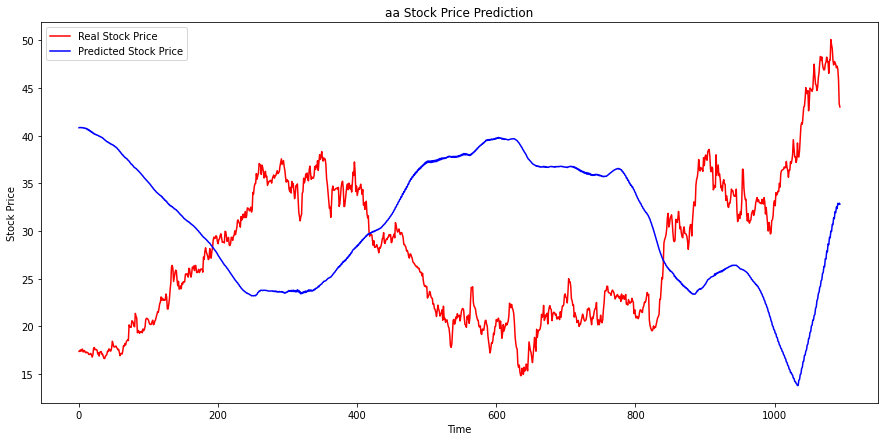

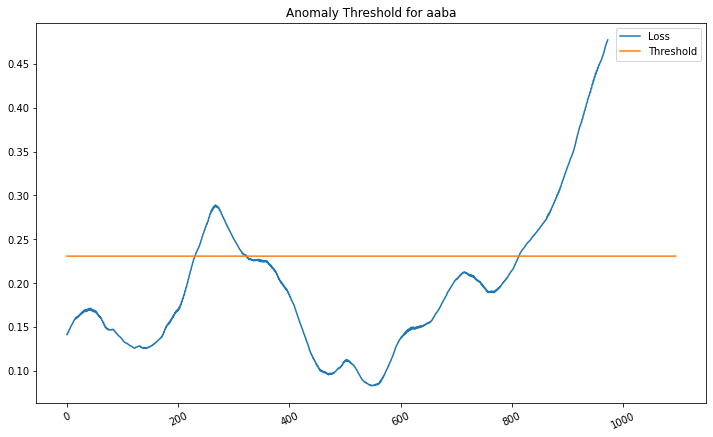

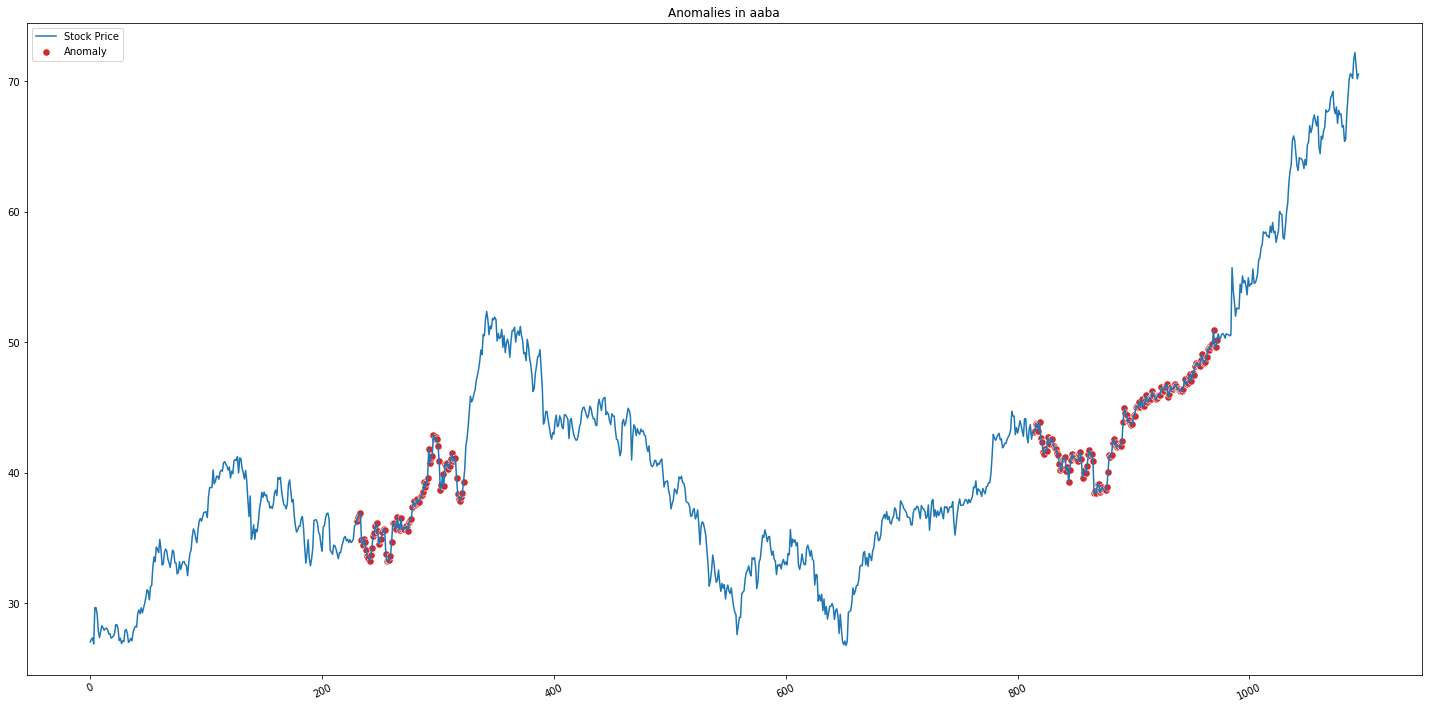

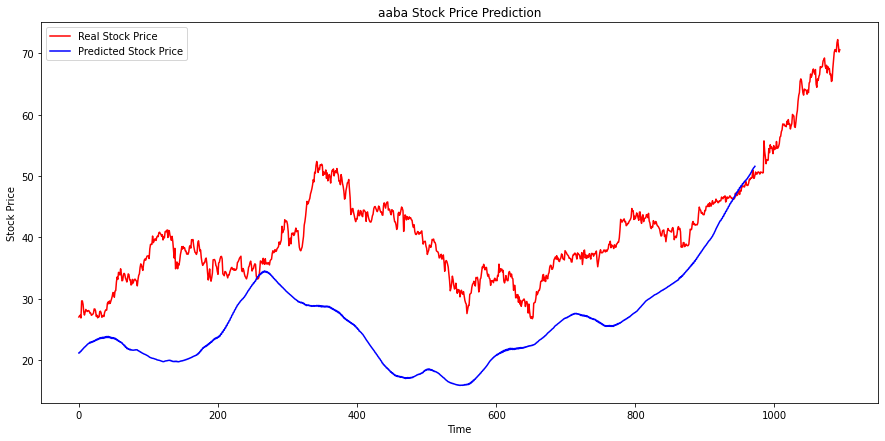

In [ ]:
hyperparameters = {'lstm_dims':[10, 3], 'dropout':0.1, 'n_time_steps':60, 'lag':2, 'batch_size':32, 'max_epochs':100, 'anomaly_threshold':None}
B__train_model_for_N_stocks(df, hyperparameters, 3)

Epoch 1/100
67/67 [==============================] - 19s 100ms/step - loss: 0.0738 - mean_absolute_error: 0.2143 - val_loss: 0.0885 - val_mean_absolute_error: 0.2759
Epoch 2/100
67/67 [==============================] - 4s 63ms/step - loss: 0.0420 - mean_absolute_error: 0.1615 - val_loss: 0.0815 - val_mean_absolute_error: 0.2695
Epoch 3/100
67/67 [==============================] - 4s 62ms/step - loss: 0.0389 - mean_absolute_error: 0.1561 - val_loss: 0.0541 - val_mean_absolute_error: 0.2125
Epoch 4/100
67/67 [==============================] - 4s 63ms/step - loss: 0.0374 - mean_absolute_error: 0.1532 - val_loss: 0.0552 - val_mean_absolute_error: 0.2185
Epoch 5/100
67/67 [==============================] - 4s 64ms/step - loss: 0.0363 - mean_absolute_error: 0.1516 - val_loss: 0.0791 - val_mean_absolute_error: 0.2706


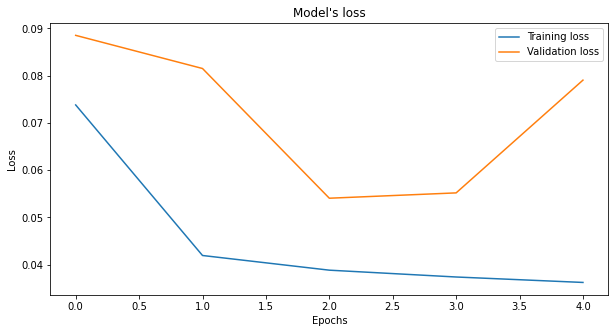

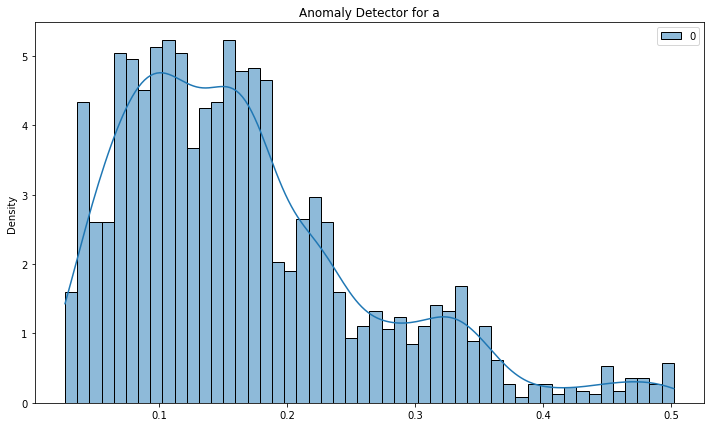

0.5021063685417175


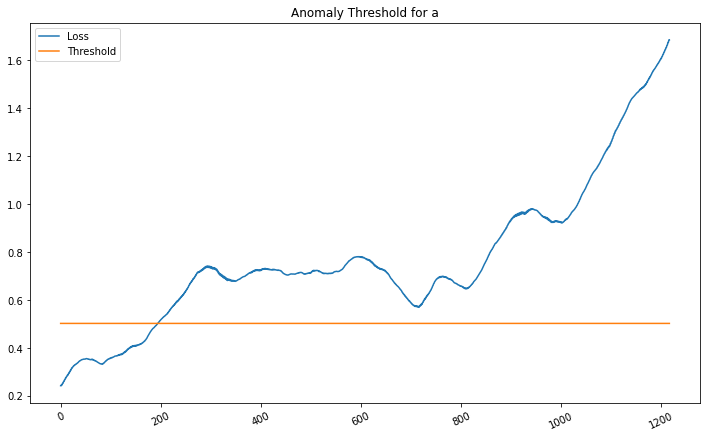

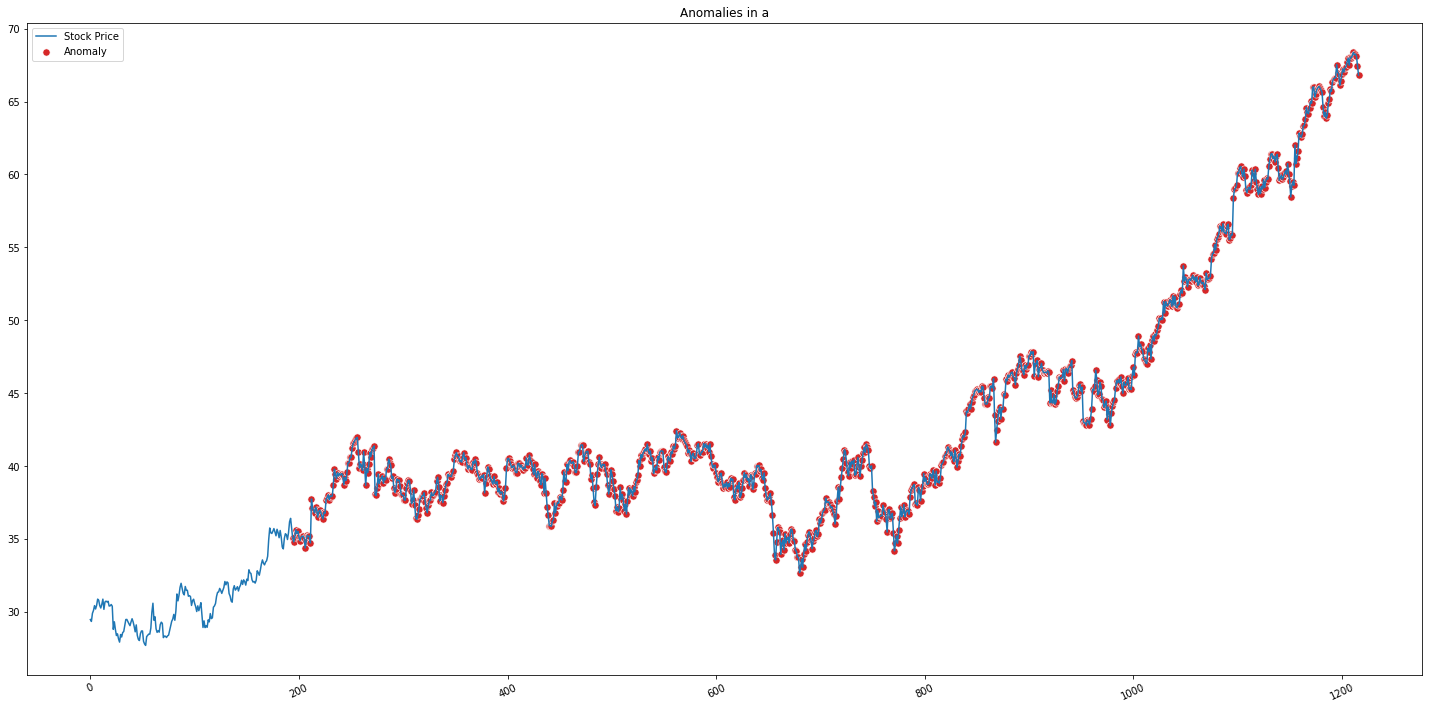

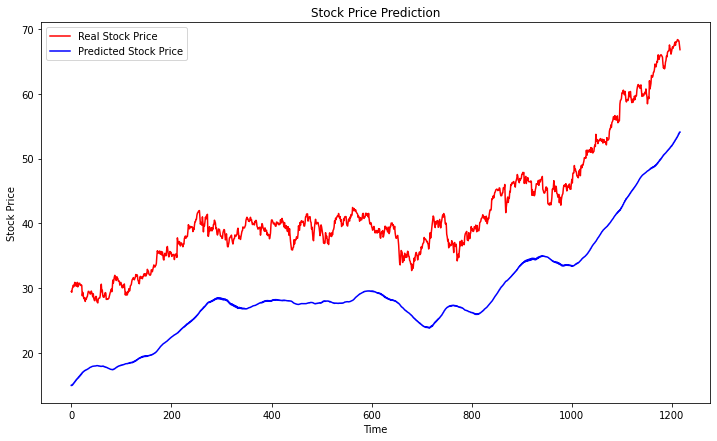

In [ ]:
hyperparameters = {'lstm_dims':[50, 10, 5], 'label':'a', 'dropout':0.2, 'n_time_steps':60, 'lag':2, 'batch_size':32, 'max_epochs':100, 'anomaly_threshold':None}
B__train_model_for_a_stock(df, hyperparameters)

### C

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 1)]           0         
                                                                 
 conv1d_63 (Conv1D)          (None, 64, 128)           512       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 32, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_64 (Conv1D)          (None, 32, 64)            24640     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 16, 32)            617

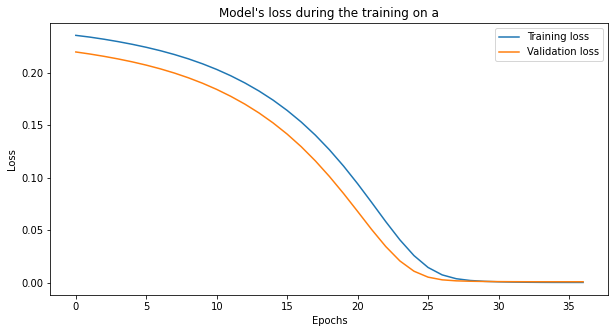

Epoch 1/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0013 - mean_absolute_error: 0.0321 - val_loss: 3.7711e-04 - val_mean_absolute_error: 0.0186
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - mean_absolute_error: 0.0322 - val_loss: 3.7933e-04 - val_mean_absolute_error: 0.0187
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0013 - mean_absolute_error: 0.0323 - val_loss: 3.8135e-04 - val_mean_absolute_error: 0.0188


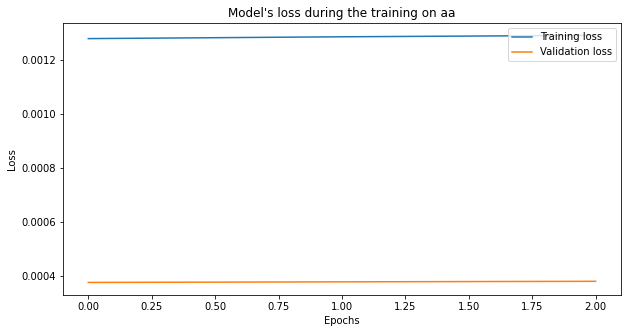

Epoch 1/50
1/1 [==============================] - 0s 73ms/step - loss: 2.6270e-04 - mean_absolute_error: 0.0152 - val_loss: 8.2648e-04 - val_mean_absolute_error: 0.0281
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 2.6392e-04 - mean_absolute_error: 0.0153 - val_loss: 8.2836e-04 - val_mean_absolute_error: 0.0281
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 2.6489e-04 - mean_absolute_error: 0.0153 - val_loss: 8.2970e-04 - val_mean_absolute_error: 0.0281


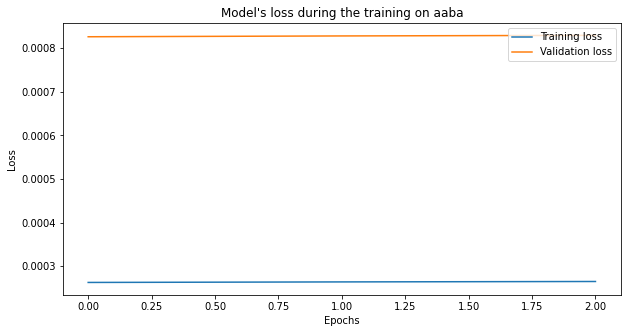

Epoch 1/50
1/1 [==============================] - 0s 75ms/step - loss: 5.2531e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0057 - val_mean_absolute_error: 0.0732
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 5.2583e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0057 - val_mean_absolute_error: 0.0732
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 5.2620e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0057 - val_mean_absolute_error: 0.0732


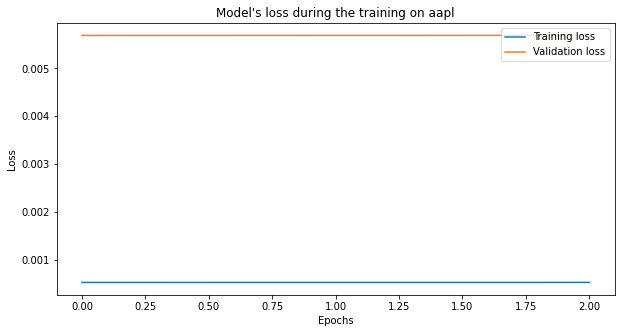

Epoch 1/50
1/1 [==============================] - 0s 74ms/step - loss: 2.8195e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0033 - val_mean_absolute_error: 0.0567
Epoch 2/50
1/1 [==============================] - 0s 48ms/step - loss: 2.8218e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0033 - val_mean_absolute_error: 0.0567
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 2.8235e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0033 - val_mean_absolute_error: 0.0567


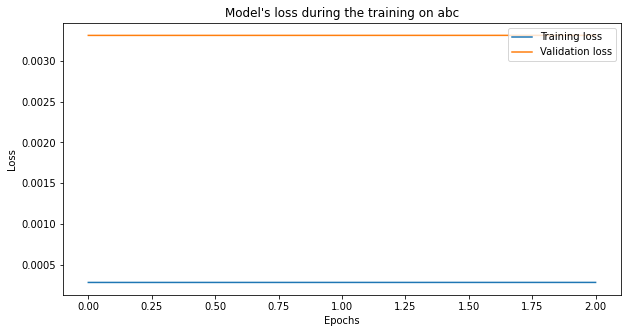

Epoch 1/50
1/1 [==============================] - 0s 76ms/step - loss: 2.0612e-04 - mean_absolute_error: 0.0142 - val_loss: 7.9880e-04 - val_mean_absolute_error: 0.0280
Epoch 2/50
1/1 [==============================] - 0s 46ms/step - loss: 2.0621e-04 - mean_absolute_error: 0.0142 - val_loss: 7.9891e-04 - val_mean_absolute_error: 0.0280
Epoch 3/50
1/1 [==============================] - 0s 56ms/step - loss: 2.0628e-04 - mean_absolute_error: 0.0142 - val_loss: 7.9899e-04 - val_mean_absolute_error: 0.0280


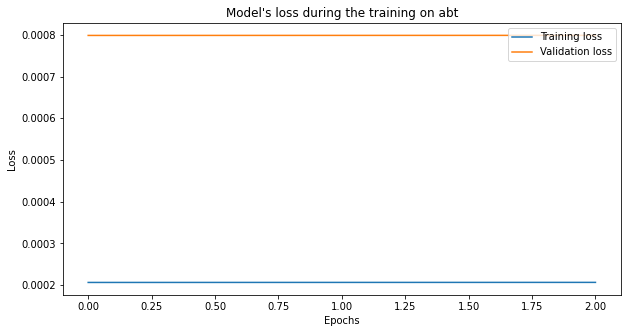

Epoch 1/50
1/1 [==============================] - 0s 72ms/step - loss: 5.0161e-04 - mean_absolute_error: 0.0215 - val_loss: 1.1049e-04 - val_mean_absolute_error: 0.0101
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 5.0166e-04 - mean_absolute_error: 0.0215 - val_loss: 1.1052e-04 - val_mean_absolute_error: 0.0102
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 5.0170e-04 - mean_absolute_error: 0.0215 - val_loss: 1.1054e-04 - val_mean_absolute_error: 0.0102


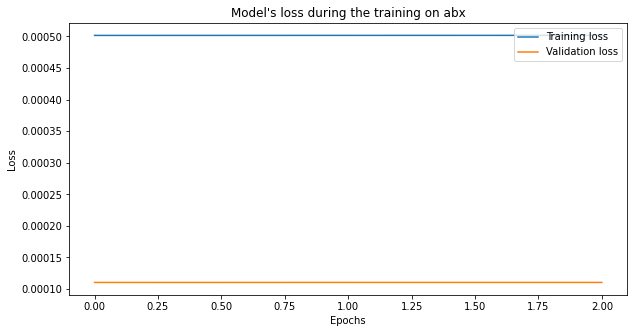

Epoch 1/50
1/1 [==============================] - 0s 72ms/step - loss: 4.9468e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0042 - val_mean_absolute_error: 0.0618
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 4.9471e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0042 - val_mean_absolute_error: 0.0618
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 4.9473e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0042 - val_mean_absolute_error: 0.0618


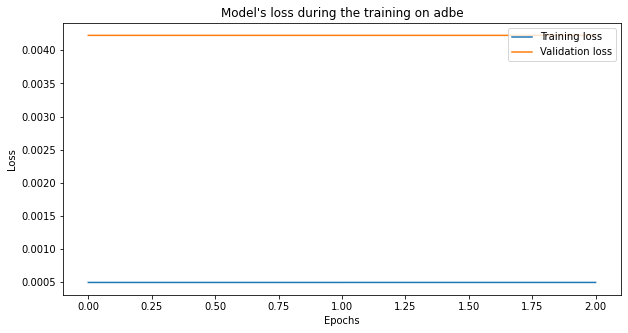

Epoch 1/50
1/1 [==============================] - 0s 76ms/step - loss: 4.1748e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0017 - val_mean_absolute_error: 0.0400
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 4.1749e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0017 - val_mean_absolute_error: 0.0400
Epoch 3/50
1/1 [==============================] - 0s 58ms/step - loss: 4.1750e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0017 - val_mean_absolute_error: 0.0400


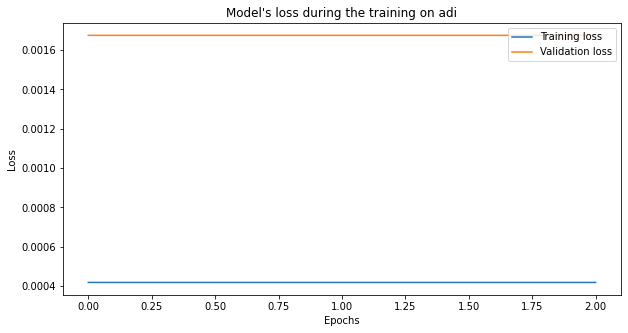

Epoch 1/50
1/1 [==============================] - 0s 78ms/step - loss: 2.9583e-04 - mean_absolute_error: 0.0166 - val_loss: 8.0705e-04 - val_mean_absolute_error: 0.0282
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 2.9584e-04 - mean_absolute_error: 0.0166 - val_loss: 8.0706e-04 - val_mean_absolute_error: 0.0282
Epoch 3/50
1/1 [==============================] - 0s 47ms/step - loss: 2.9584e-04 - mean_absolute_error: 0.0166 - val_loss: 8.0707e-04 - val_mean_absolute_error: 0.0282


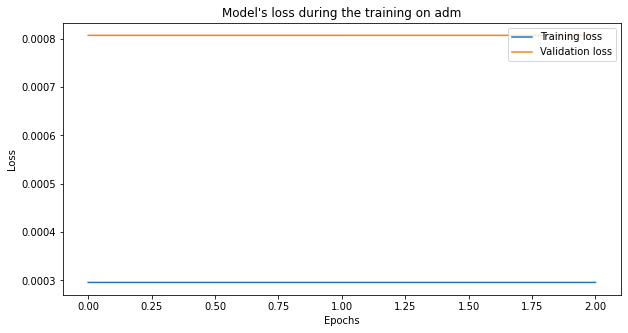

Epoch 1/50
1/1 [==============================] - 0s 71ms/step - loss: 5.5419e-04 - mean_absolute_error: 0.0142 - val_loss: 1.1507e-05 - val_mean_absolute_error: 0.0032
Epoch 2/50
1/1 [==============================] - 0s 52ms/step - loss: 5.5420e-04 - mean_absolute_error: 0.0142 - val_loss: 1.1508e-05 - val_mean_absolute_error: 0.0032
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 5.5420e-04 - mean_absolute_error: 0.0142 - val_loss: 1.1509e-05 - val_mean_absolute_error: 0.0032


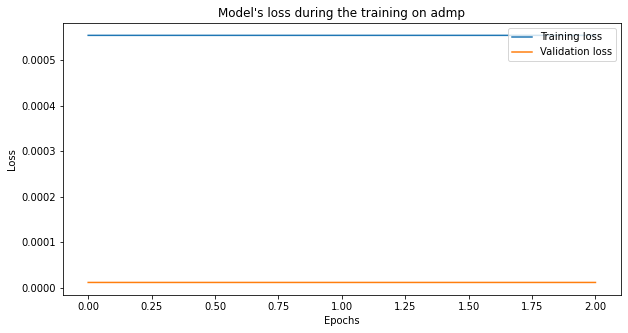

Epoch 1/50
1/1 [==============================] - 0s 78ms/step - loss: 5.1702e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0032 - val_mean_absolute_error: 0.0559
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 5.1702e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0032 - val_mean_absolute_error: 0.0559
Epoch 3/50
1/1 [==============================] - 0s 52ms/step - loss: 5.1703e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0032 - val_mean_absolute_error: 0.0559


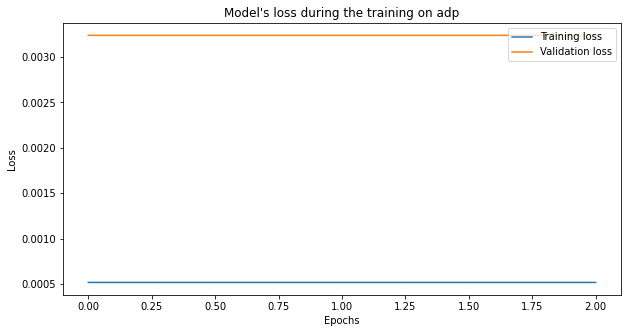

Epoch 1/50
1/1 [==============================] - 0s 76ms/step - loss: 5.1873e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0021 - val_mean_absolute_error: 0.0440
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 5.1873e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0021 - val_mean_absolute_error: 0.0440
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 5.1873e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0021 - val_mean_absolute_error: 0.0440


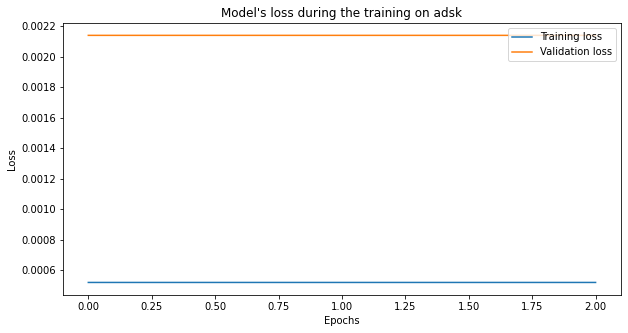

Epoch 1/50
1/1 [==============================] - 0s 70ms/step - loss: 4.5553e-04 - mean_absolute_error: 0.0207 - val_loss: 8.8082e-04 - val_mean_absolute_error: 0.0291
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 4.5553e-04 - mean_absolute_error: 0.0207 - val_loss: 8.8082e-04 - val_mean_absolute_error: 0.0291
Epoch 3/50
1/1 [==============================] - 0s 49ms/step - loss: 4.5553e-04 - mean_absolute_error: 0.0207 - val_loss: 8.8083e-04 - val_mean_absolute_error: 0.0291


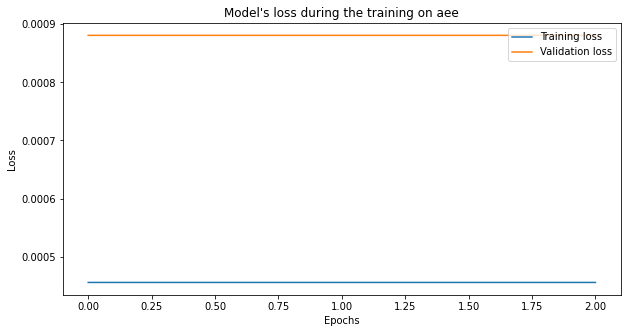

Epoch 1/50
1/1 [==============================] - 0s 82ms/step - loss: 8.2360e-04 - mean_absolute_error: 0.0256 - val_loss: 6.4514e-04 - val_mean_absolute_error: 0.0245
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 8.2360e-04 - mean_absolute_error: 0.0256 - val_loss: 6.4514e-04 - val_mean_absolute_error: 0.0245
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 8.2360e-04 - mean_absolute_error: 0.0256 - val_loss: 6.4514e-04 - val_mean_absolute_error: 0.0245


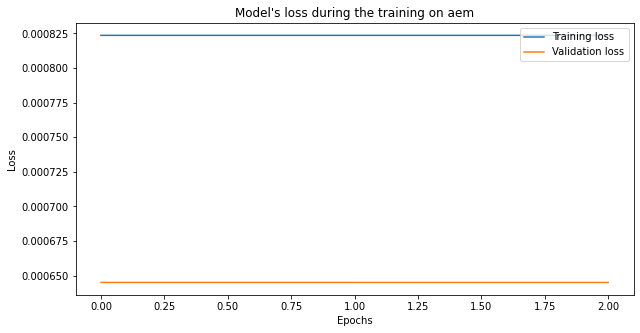

Epoch 1/50
1/1 [==============================] - 0s 74ms/step - loss: 3.9119e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0015 - val_mean_absolute_error: 0.0376
Epoch 2/50
1/1 [==============================] - 0s 57ms/step - loss: 3.9119e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0015 - val_mean_absolute_error: 0.0376
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 3.9120e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0015 - val_mean_absolute_error: 0.0376


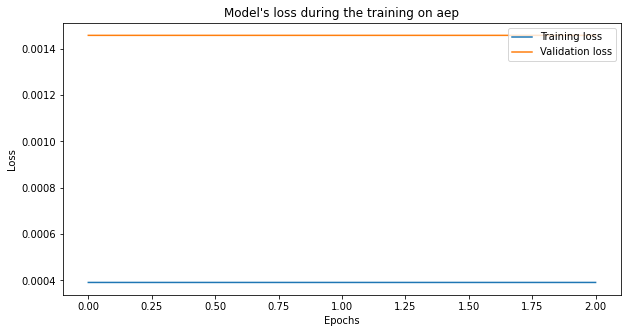

Epoch 1/50
1/1 [==============================] - 0s 72ms/step - loss: 7.0379e-05 - mean_absolute_error: 0.0080 - val_loss: 5.9606e-05 - val_mean_absolute_error: 0.0077
Epoch 2/50
1/1 [==============================] - 0s 52ms/step - loss: 7.0379e-05 - mean_absolute_error: 0.0080 - val_loss: 5.9606e-05 - val_mean_absolute_error: 0.0077
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 7.0379e-05 - mean_absolute_error: 0.0080 - val_loss: 5.9607e-05 - val_mean_absolute_error: 0.0077


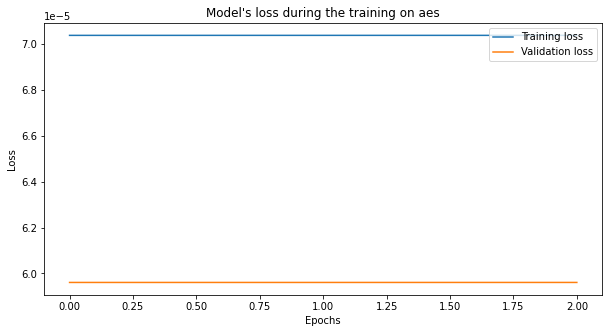

Epoch 1/50
1/1 [==============================] - 0s 76ms/step - loss: 5.6959e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0054 - val_mean_absolute_error: 0.0712
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 5.6959e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0054 - val_mean_absolute_error: 0.0712
Epoch 3/50
1/1 [==============================] - 0s 53ms/step - loss: 5.6959e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0054 - val_mean_absolute_error: 0.0712


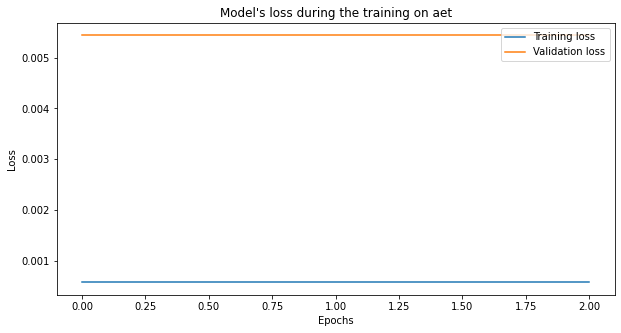

Epoch 1/50
1/1 [==============================] - 0s 70ms/step - loss: 7.4612e-04 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0436
Epoch 2/50
1/1 [==============================] - 0s 55ms/step - loss: 7.4612e-04 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0436
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 7.4612e-04 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0436


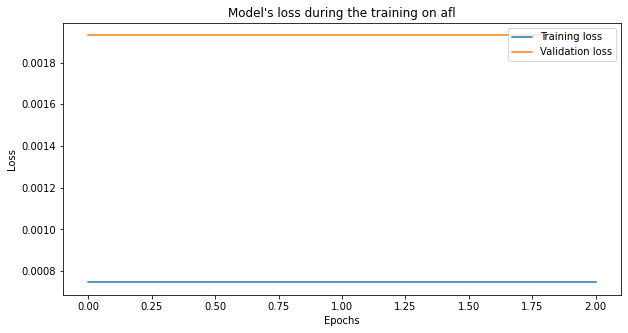

Epoch 1/50
1/1 [==============================] - 0s 71ms/step - loss: 9.6804e-04 - mean_absolute_error: 0.0286 - val_loss: 0.0276 - val_mean_absolute_error: 0.1628
Epoch 2/50
1/1 [==============================] - 0s 52ms/step - loss: 9.6804e-04 - mean_absolute_error: 0.0286 - val_loss: 0.0276 - val_mean_absolute_error: 0.1628
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 9.6804e-04 - mean_absolute_error: 0.0286 - val_loss: 0.0276 - val_mean_absolute_error: 0.1628


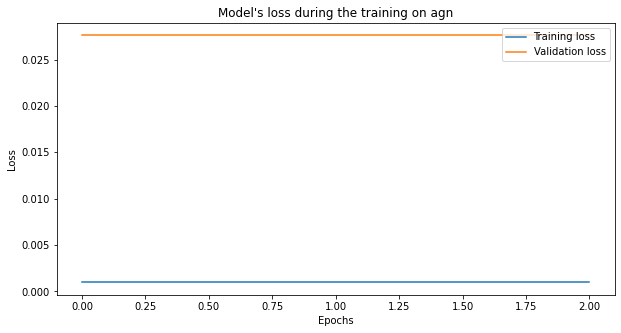

Epoch 1/50
1/1 [==============================] - 0s 74ms/step - loss: 0.3553 - mean_absolute_error: 0.4397 - val_loss: 0.0014 - val_mean_absolute_error: 0.0378
Epoch 2/50
1/1 [==============================] - 0s 46ms/step - loss: 0.3553 - mean_absolute_error: 0.4397 - val_loss: 0.0014 - val_mean_absolute_error: 0.0378
Epoch 3/50
1/1 [==============================] - 0s 66ms/step - loss: 0.3553 - mean_absolute_error: 0.4397 - val_loss: 0.0014 - val_mean_absolute_error: 0.0378


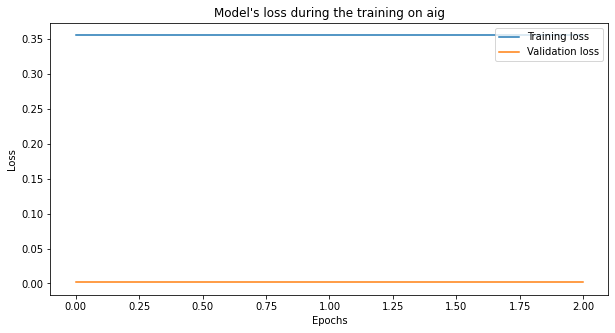

Epoch 1/50
1/1 [==============================] - 0s 75ms/step - loss: 3.7238e-04 - mean_absolute_error: 0.0179 - val_loss: 6.2426e-04 - val_mean_absolute_error: 0.0245
Epoch 2/50
1/1 [==============================] - 0s 56ms/step - loss: 3.7238e-04 - mean_absolute_error: 0.0179 - val_loss: 6.2426e-04 - val_mean_absolute_error: 0.0245
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 3.7238e-04 - mean_absolute_error: 0.0179 - val_loss: 6.2426e-04 - val_mean_absolute_error: 0.0245


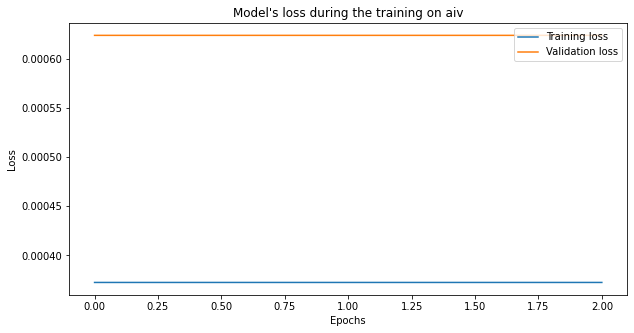

Epoch 1/50
1/1 [==============================] - 0s 69ms/step - loss: 6.9431e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0021 - val_mean_absolute_error: 0.0447
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 6.9431e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0021 - val_mean_absolute_error: 0.0447
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 6.9431e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0021 - val_mean_absolute_error: 0.0447


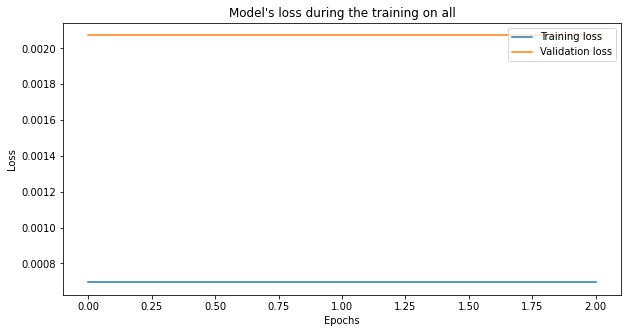

Epoch 1/50
1/1 [==============================] - 0s 72ms/step - loss: 8.8956e-05 - mean_absolute_error: 0.0092 - val_loss: 3.3267e-04 - val_mean_absolute_error: 0.0169
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 8.8956e-05 - mean_absolute_error: 0.0092 - val_loss: 3.3267e-04 - val_mean_absolute_error: 0.0169
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 8.8956e-05 - mean_absolute_error: 0.0092 - val_loss: 3.3267e-04 - val_mean_absolute_error: 0.0169


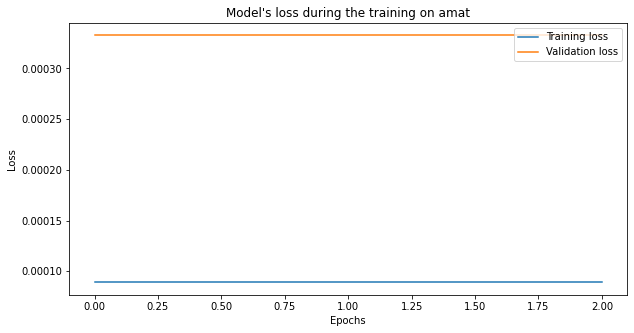

Epoch 1/50
1/1 [==============================] - 0s 72ms/step - loss: 9.2591e-05 - mean_absolute_error: 0.0078 - val_loss: 2.0239e-05 - val_mean_absolute_error: 0.0036
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 9.2591e-05 - mean_absolute_error: 0.0078 - val_loss: 2.0239e-05 - val_mean_absolute_error: 0.0036
Epoch 3/50
1/1 [==============================] - 0s 53ms/step - loss: 9.2591e-05 - mean_absolute_error: 0.0078 - val_loss: 2.0239e-05 - val_mean_absolute_error: 0.0036


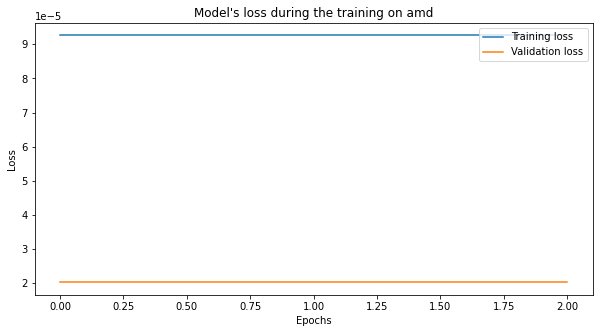

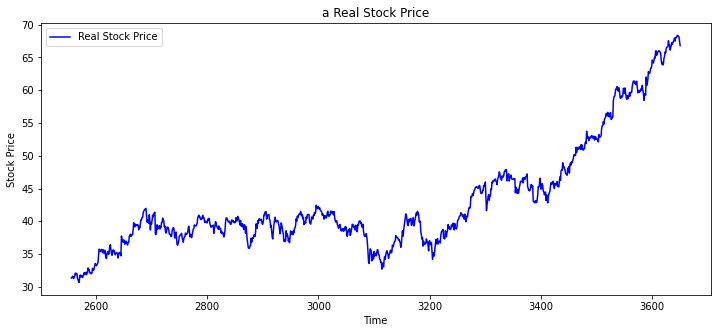

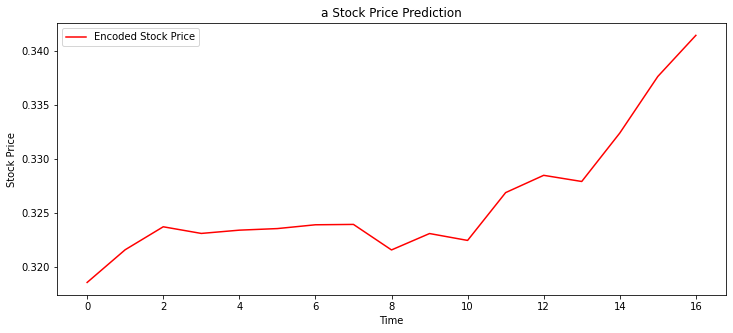

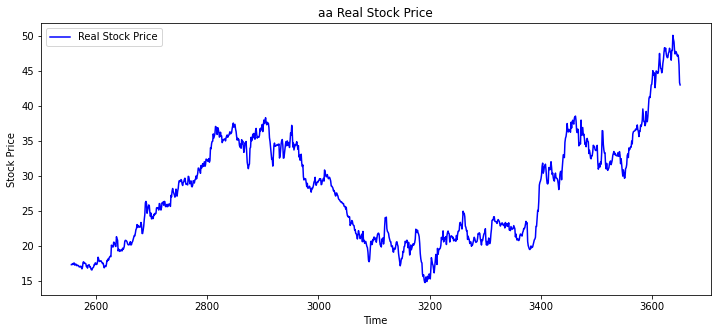

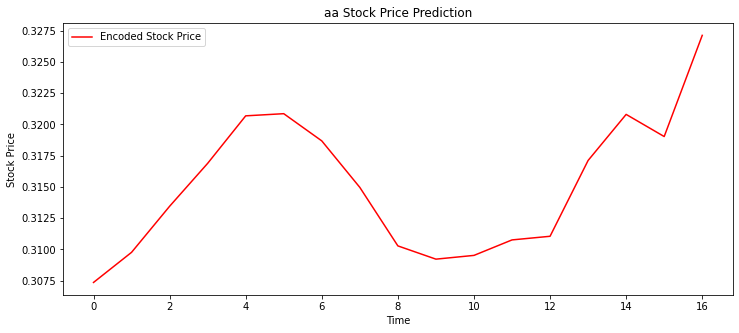

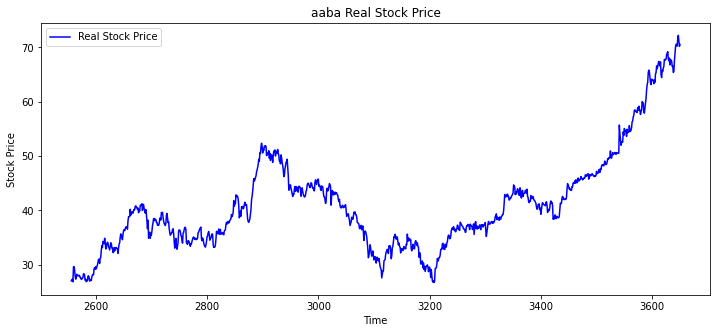

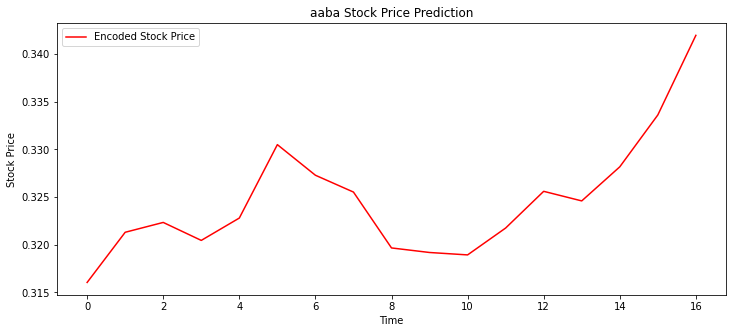

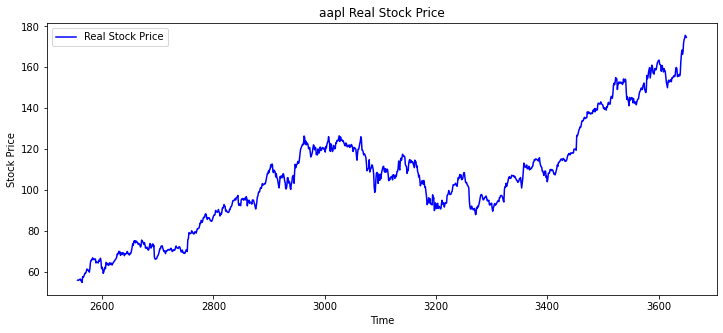

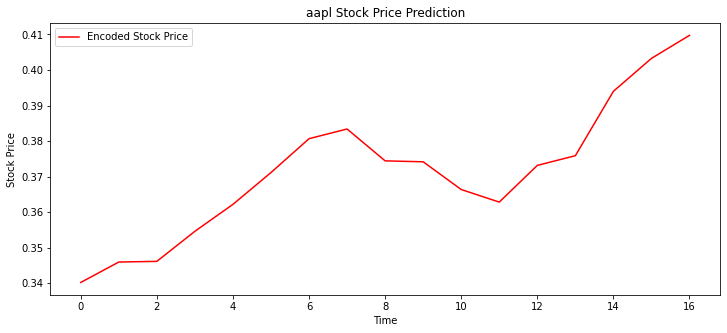

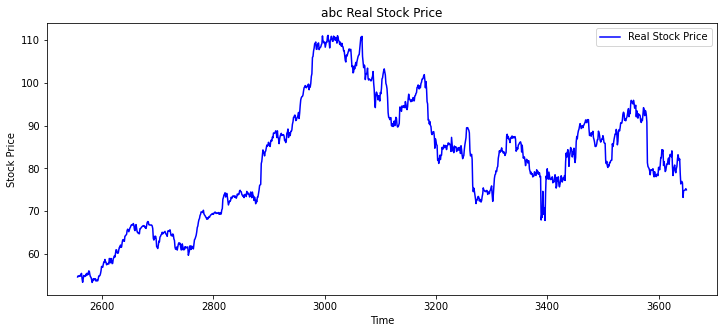

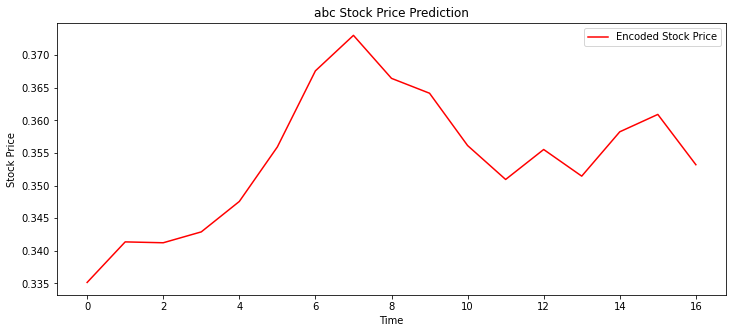

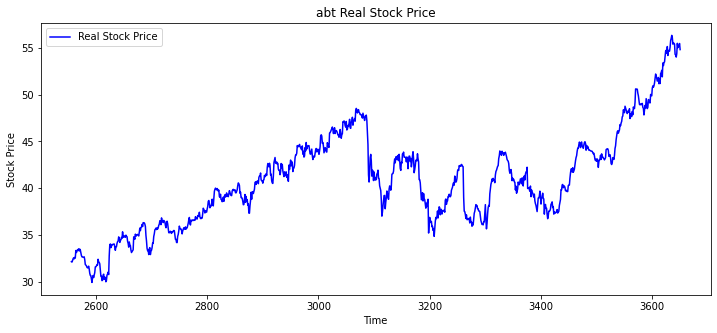

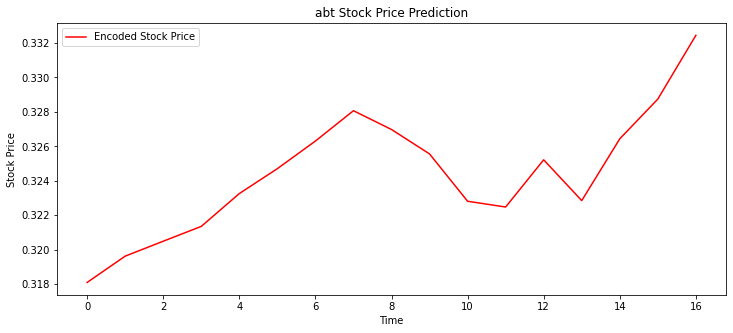

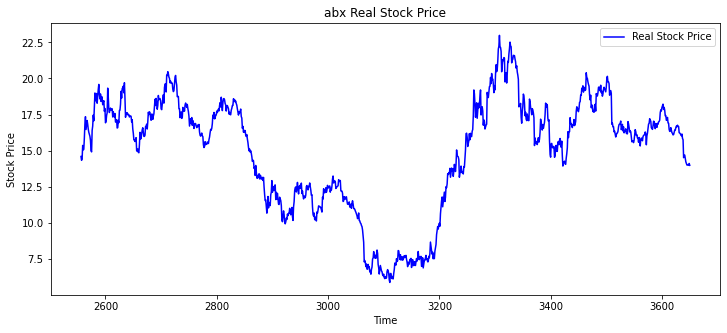

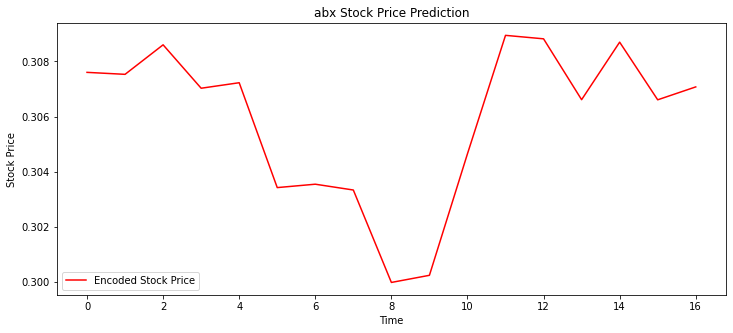

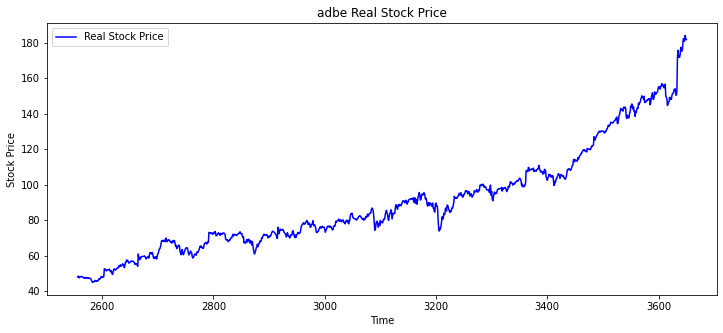

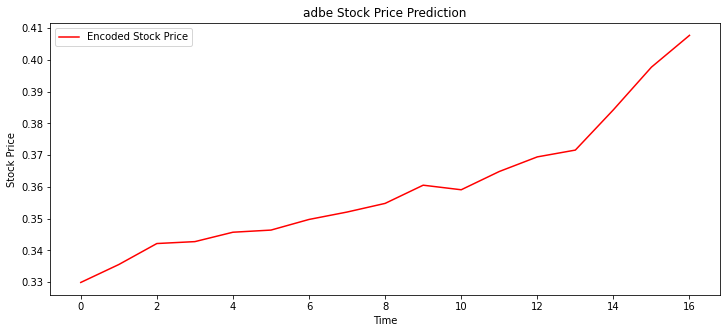

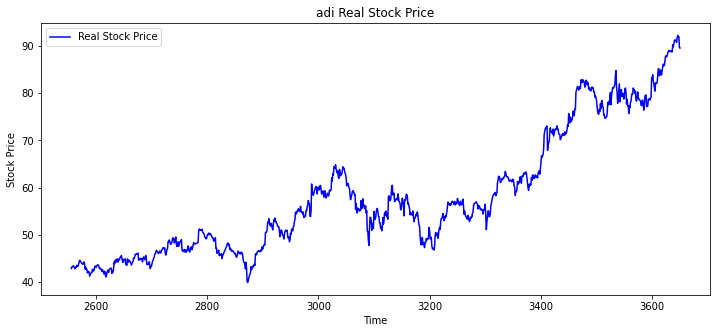

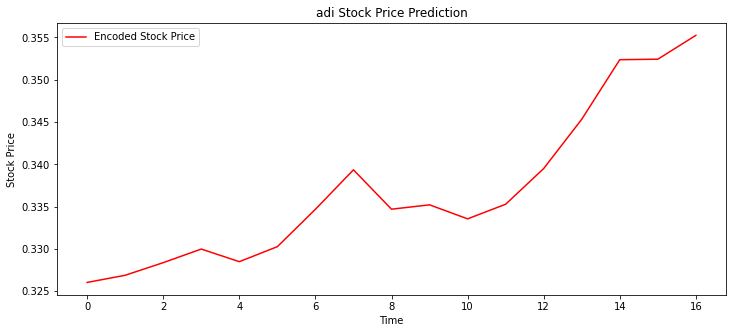

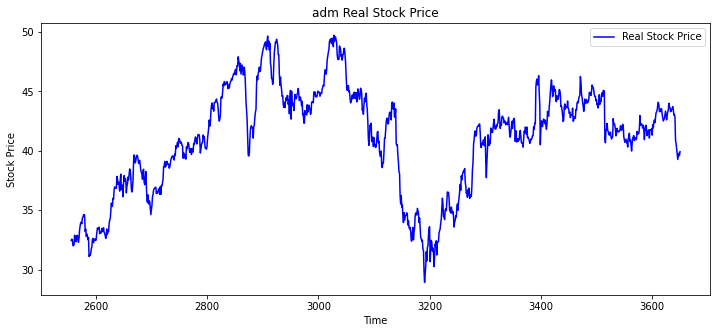

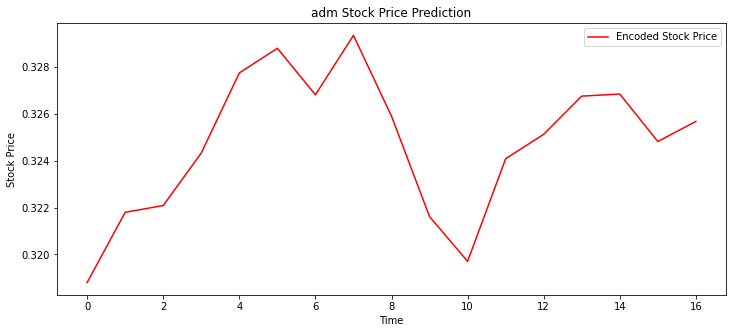

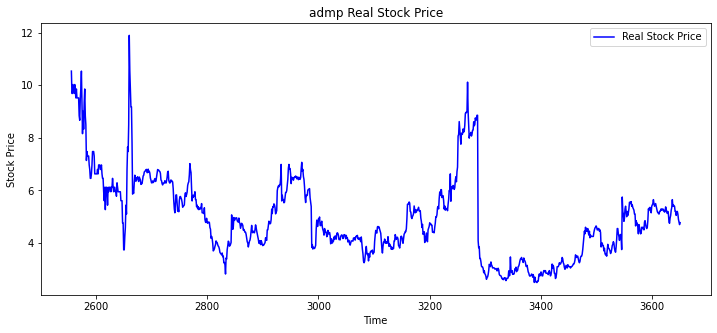

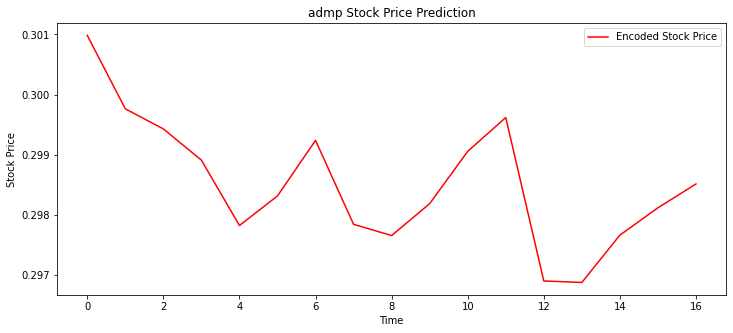

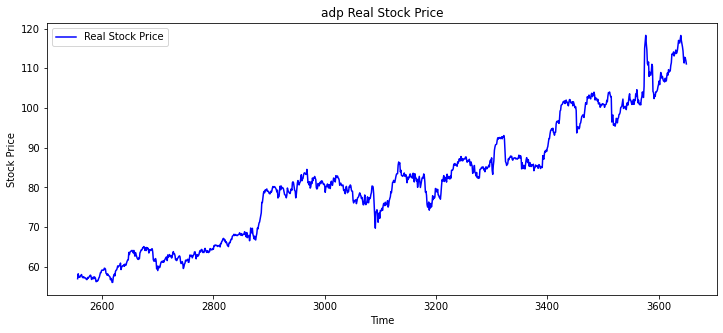

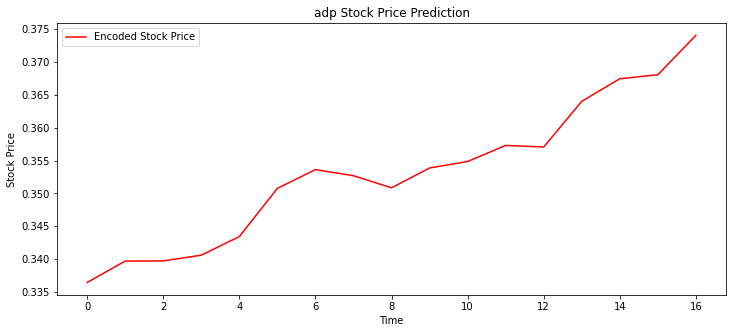

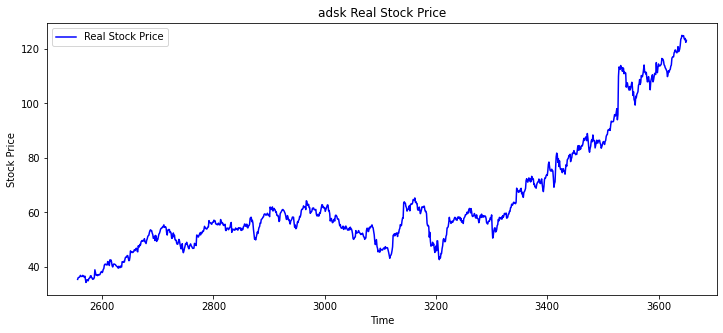

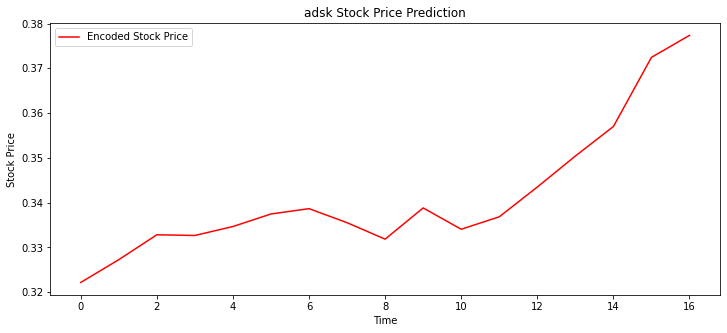

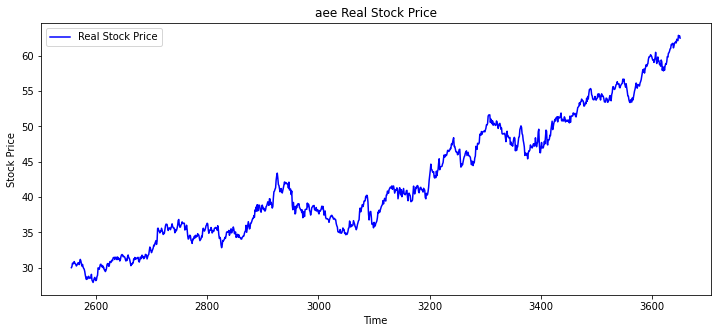

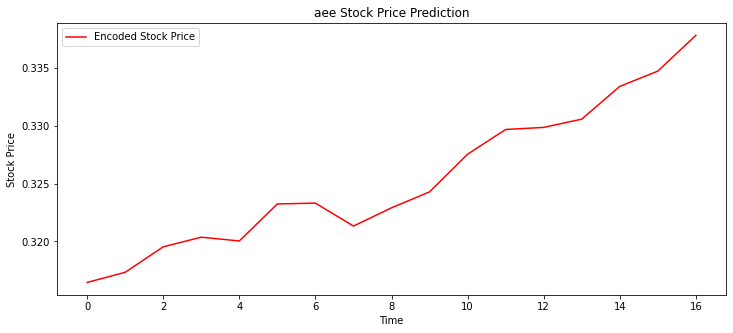

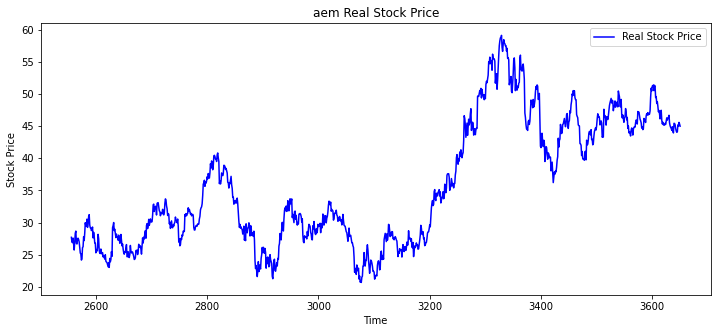

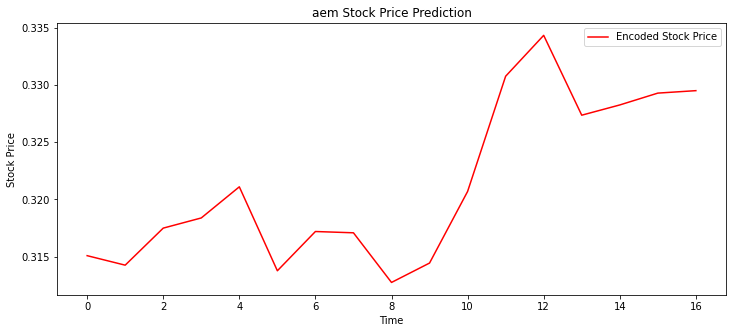

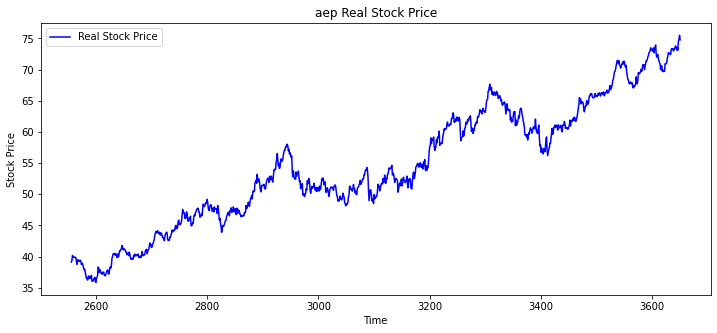

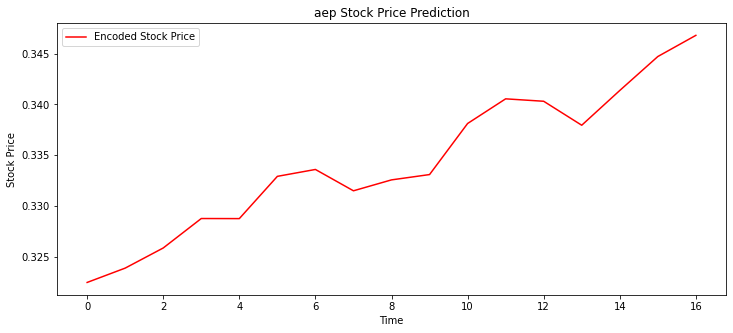

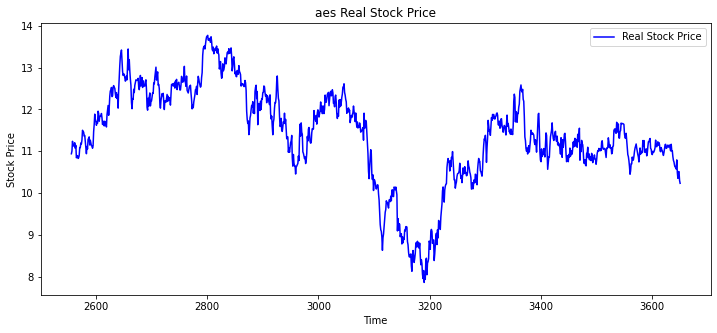

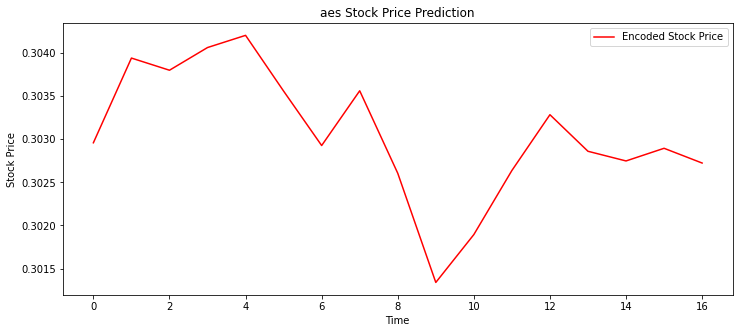

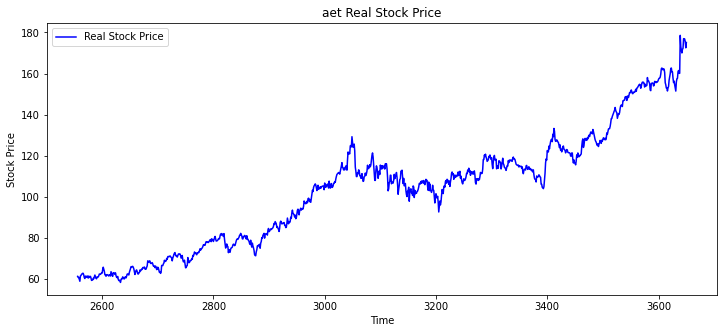

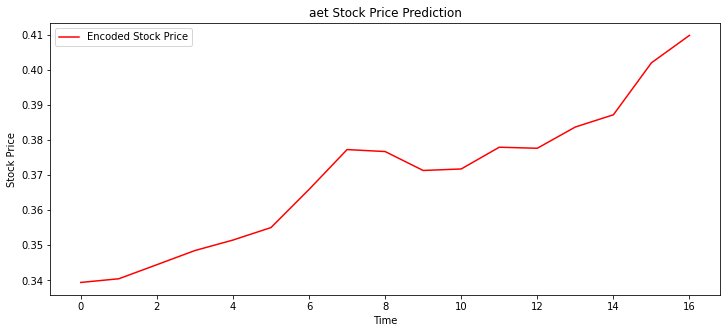

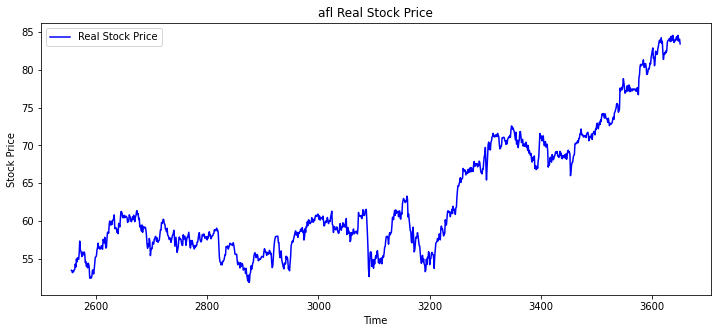

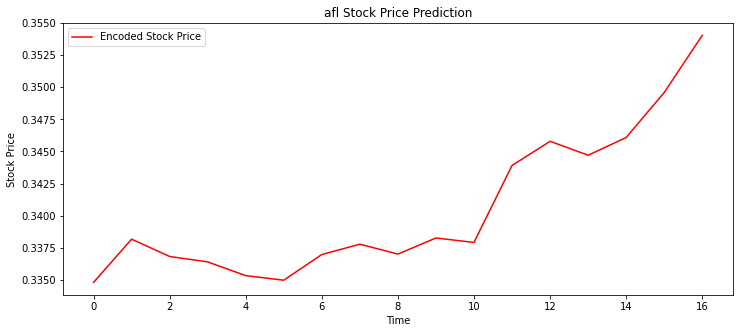

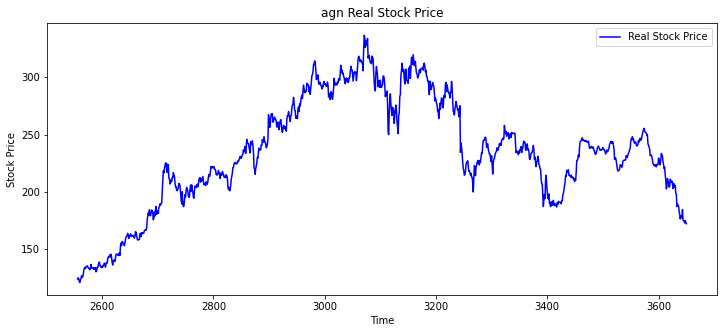

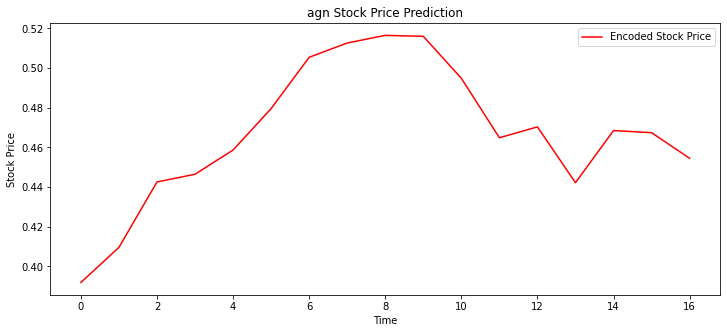

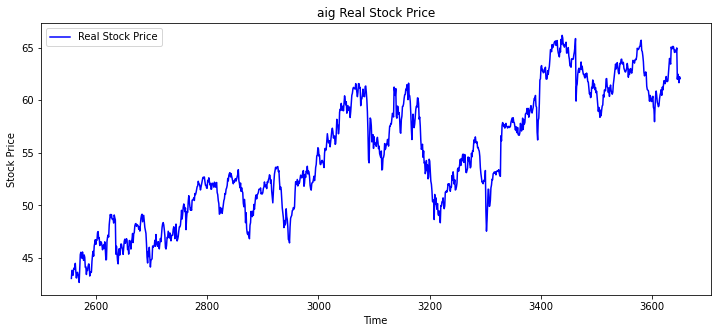

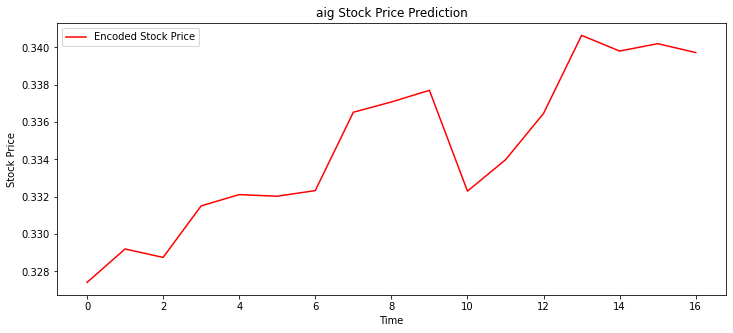

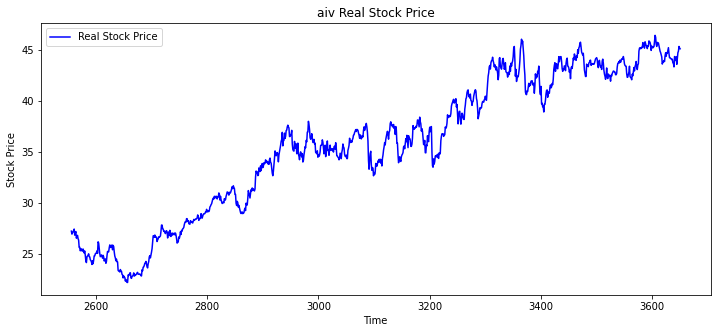

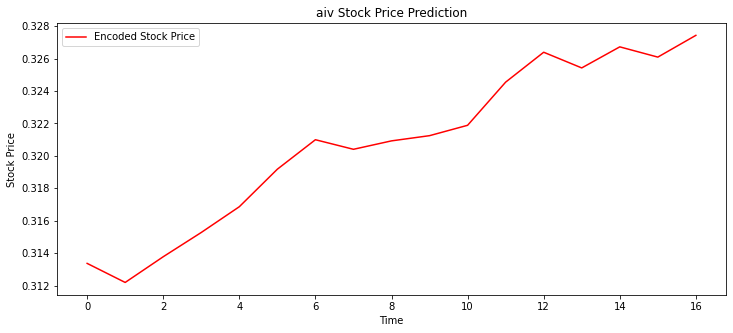

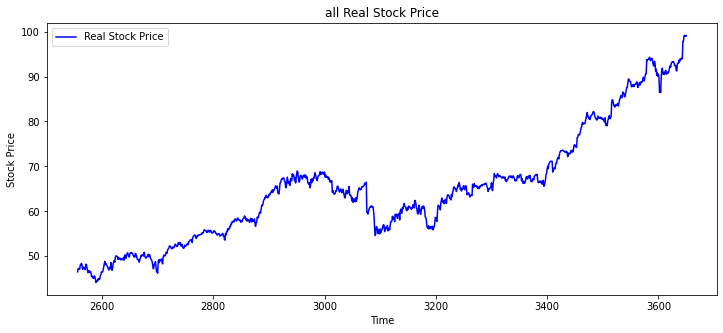

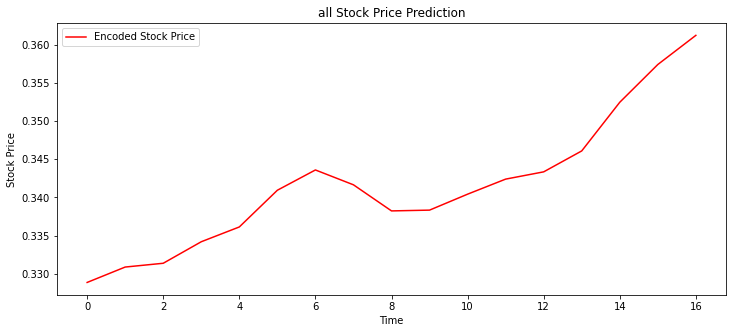

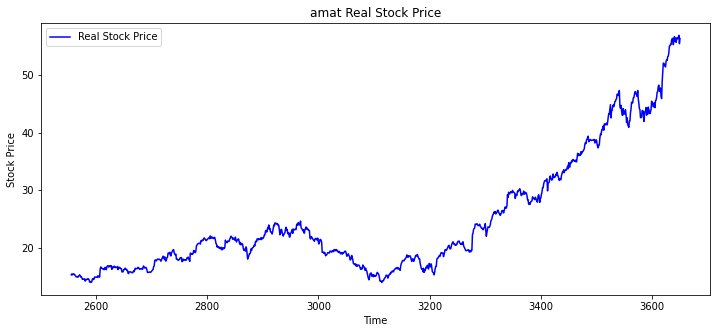

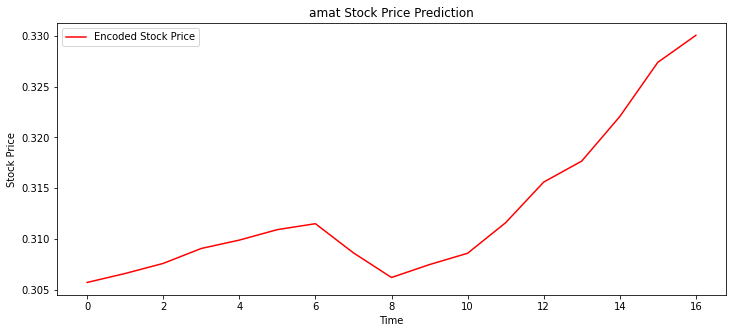

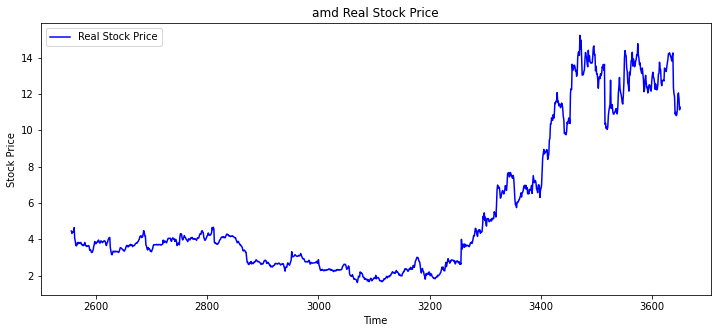

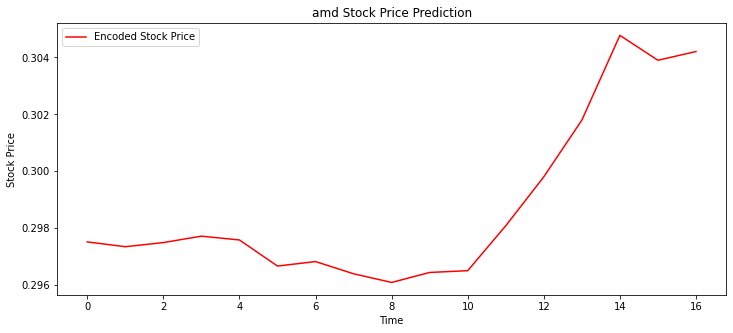

In [ ]:
hyperparameters = {'conv_filters':[128, 64, 32, 18], 'kernels':[3, 3, 3, 3], 'batch_size':64, 'max_epochs':50, 'window_size':64, 'latent_dim':35}
C__train_model_for_N_stocks(df, hyperparameters, 25)

In [ ]:
latent_dims = [2, 3, 5, 7, 10, 13, 15]
conv_filters_to_test = [ [200, 150, 100, 50, 25, 5], [100, 75, 50, 25, 5], [50, 40, 30, 20, 10, 5], [40, 20, 10, 5], [50, 30, 10, 5, 5], [30, 10, 8, 4], [30, 10, 8], [20, 10, 5], [10, 5, 5], [10,5] ]
batch_size_to_test = [8, 32, 64, 128, 512, 1024]
window_size = [1, 15, 30, 60, 90, 120, 150]

def test_batch3(df, hp):
    for i in batch_size_to_test:
        print('Batch size = ', i)
        hp['batch_size'] = i
        C__train_model_for_a_stock(df, hyperparameters)

def test_conv_filters3(df, hp):
    for i in conv_filters_to_test:
        print('Conv filters: ', i)
        hp['conv_filters'] = i
        hp['kernels'] = len(hp['conv_filters']) * [hp['latent_dim']]
        C__train_model_for_a_stock(df, hyperparameters)

def test_latent_dim(df, hp):
    for i in latent_dims:
        print('latent_dim: ', i)
        hp['latent_dim'] = i
        hp['kernels'] = len(hp['conv_filters']) * [i]
        C__train_model_for_a_stock(df, hyperparameters)

def test_ws(df, hp):
    for i in window_size:
        print('window_size: ', i)
        hp['window_size'] = i
        C__train_model_for_a_stock(df, hyperparameters)

Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 36, 1)]           0         
                                                                 
 conv1d_228 (Conv1D)         (None, 36, 30)            120       
                                                                 
 max_pooling1d_99 (MaxPoolin  (None, 18, 30)           0         
 g1D)                                                            
                                                                 
 conv1d_229 (Conv1D)         (None, 18, 10)            910       
                                                                 
 max_pooling1d_100 (MaxPooli  (None, 9, 10)            0         
 ng1D)                                                           
                                                                 
 conv1d_230 (Conv1D)         (None, 9, 8)              248

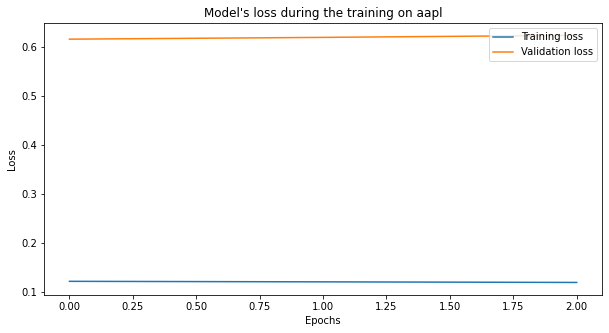

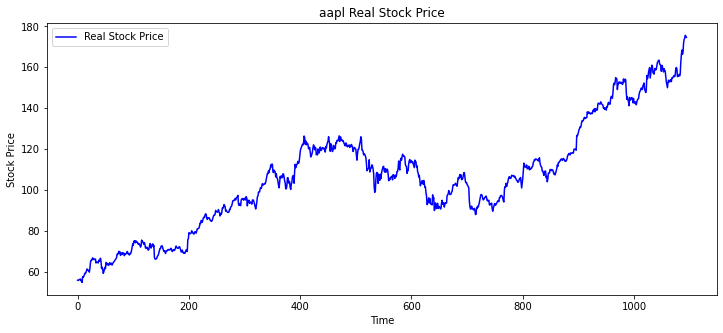

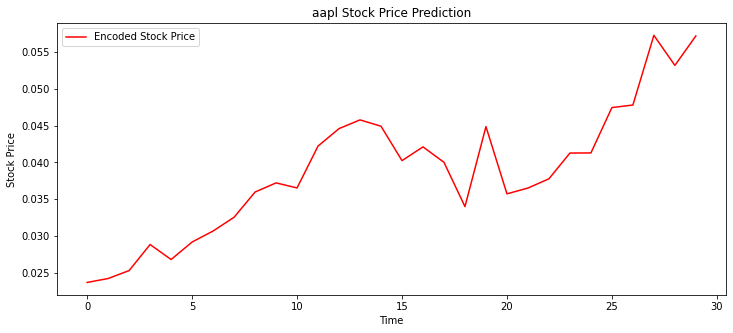

In [ ]:
hyperparameters = {'conv_filters':[30, 10, 8], 'kernels':[3, 3, 3], 'label':'aapl', 'batch_size':64, 'max_epochs':300, 'window_size':36, 'latent_dim':3}
C__train_model_for_a_stock(df, hyperparameters)

---
### *End of Project*